In [121]:
print("1. Importing standard libraries...")
import sys
import os

# CRITICAL FIX: Prevent OpenMP runtime conflicts causing kernel crashes/freezes
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import warnings
import json
from pathlib import Path

print("2. Importing numpy/pandas...")
# Check if already imported to avoid re-initialization hangs
if 'numpy' not in sys.modules:
    import numpy as np
else:
    np = sys.modules['numpy']
    print("  (numpy already imported)")

if 'pandas' not in sys.modules:
    import pandas as pd
else:
    pd = sys.modules['pandas']
    print("  (pandas already imported)")

print("3. Importing sklearn...")
if 'sklearn' not in sys.modules:
    from sklearn.model_selection import train_test_split
else:
    print("   sklearn already loaded")
    from sklearn.model_selection import train_test_split

print("4. Importing scipy...")
if 'scipy' not in sys.modules:
    from scipy.stats import chi2_contingency
else:
    print("   scipy already loaded")
    from scipy.stats import chi2_contingency

print("5. Configuring environment...")
warnings.filterwarnings('ignore')

# ENSURE OUTPUT DIRECTORIES EXIST
print("6. Verifying output directories...")
output_dirs = ['../data', '../results/plots', '../results/tables']
for d in output_dirs:
    Path(d).mkdir(parents=True, exist_ok=True)
    print(f"   ✓ {d}")

print("Libraries loaded successfully")

1. Importing standard libraries...
2. Importing numpy/pandas...
  (numpy already imported)
  (pandas already imported)
3. Importing sklearn...
   sklearn already loaded
4. Importing scipy...
   scipy already loaded
5. Configuring environment...
6. Verifying output directories...
   ✓ ../data
   ✓ ../results/plots
   ✓ ../results/tables
Libraries loaded successfully


# AI Readiness Scale (AIRS) - Split-Sample Creation

**Purpose**: Create stratified development and holdout samples for psychometric validation

**Methodology**: Stratified random split ensuring balanced representation across Work Context × AI Adoption

**Outputs**: Development sample (EFA) + Holdout sample (CFA) + Semantic metadata

---

## 0. Configuration

In [122]:
# ═══════════════════════════════════════════════════════════════════════════════
# SUBSAMPLE CONFIGURATION - EDIT THIS TO SWITCH BETWEEN SAMPLES
# ═══════════════════════════════════════════════════════════════════════════════

# OPTIONS: 'full', 'students', 'professionals'
SUBSAMPLE_MODE = 'full'

# ═══════════════════════════════════════════════════════════════════════════════

# Validate configuration
valid_modes = ['full', 'students', 'professionals']
if SUBSAMPLE_MODE not in valid_modes:
    raise ValueError(f"Invalid SUBSAMPLE_MODE: '{SUBSAMPLE_MODE}'. Must be one of {valid_modes}")

# Display configuration
print("="*80)
print("SUBSAMPLE CONFIGURATION")
print("="*80)
print(f"Mode: {SUBSAMPLE_MODE.upper()}")

# Display configuration details dynamically
if SUBSAMPLE_MODE == 'full':
    print("Status: Using FULL SAMPLE")
    print("        - All work contexts included")
    print("        - Total N will be calculated from data")
elif SUBSAMPLE_MODE == 'students':
    print("Status: Using STUDENTS ONLY")
    print("        - Work_Context filter: 'Academic-Student'")
    print("        - Sample size determined by filter")
elif SUBSAMPLE_MODE == 'professionals':
    print("Status: Using PROFESSIONALS ONLY")
    print("        - Work_Context filter: 'Professional-*'")
    print("        - Sample size determined by filter")

print("="*80)
print("\n⚠️ IMPORTANT: After changing SUBSAMPLE_MODE, re-run ALL cells in this notebook")
print("             Then re-run Notebooks 01, 02a, 03, 04 to validate models on new sample")
print("="*80)

SUBSAMPLE CONFIGURATION
Mode: FULL
Status: Using FULL SAMPLE
        - All work contexts included
        - Total N will be calculated from data

⚠️ IMPORTANT: After changing SUBSAMPLE_MODE, re-run ALL cells in this notebook
             Then re-run Notebooks 01, 02a, 03, 04 to validate models on new sample


## 1. Semantic Metadata

In [ ]:
# Item Semantic Metadata Dictionary
# DRY approach: Define data compactly, generate full structure
# Format: (code, construct, hypothesis, question, direction, note, provenance)

items_data = [
    ('PE1', 'Performance Expectancy', 'H1', 'AI tools help me accomplish tasks more quickly.', 'POSITIVE', 'Perceived productivity gain', 'Direct (UTAUT)'),
    ('PE2', 'Performance Expectancy', 'H1', 'Using AI improves the quality of my work or studies.', 'POSITIVE', 'Perceived quality improvement', 'Direct (UTAUT)'),
    ('EE1', 'Effort Expectancy', 'H1', 'Learning to use AI tools is easy for me.', 'POSITIVE', 'Perceived ease of learning', 'Direct (UTAUT)'),
    ('EE2', 'Effort Expectancy', 'H1', 'Interacting with AI tools is clear and understandable.', 'POSITIVE', 'Perceived clarity of interaction', 'Direct (UTAUT)'),
    ('SI1', 'Social Influence', 'H1', 'People whose opinions I value encourage me to use AI tools.', 'POSITIVE', 'Social encouragement from valued others', 'Direct (UTAUT)'),
    ('SI2', 'Social Influence', 'H1', 'Leaders in my organization or school support the use of AI tools.', 'POSITIVE', 'Leadership support and organizational norms', 'Adapted (UTAUT)'),
    ('FC1', 'Facilitating Conditions', 'H1', 'I have access to training or tutorials for the AI tools I use.', 'POSITIVE', 'Resource availability and support', 'Adapted (UTAUT)'),
    ('FC2', 'Facilitating Conditions', 'H1', 'The AI tools I use are compatible with other tools or systems I use.', 'POSITIVE', 'System compatibility and integration', 'Direct (UTAUT)'),
    ('HM1', 'Hedonic Motivation', 'H1', 'Using AI tools is stimulating and engaging.', 'POSITIVE', 'Intrinsic enjoyment and stimulation', 'Direct (UTAUT2)'),
    ('HM2', 'Hedonic Motivation', 'H1', 'AI tools make my work or studies more interesting.', 'POSITIVE', 'Enhanced interest and engagement', 'Direct (UTAUT2)'),
    ('PV1', 'Price Value', 'H1', 'I get more value from AI tools than the effort they require.', 'POSITIVE', 'Perceived value-effort tradeoff', 'Adapted (UTAUT2) - effort substituted for monetary cost'),
    ('PV2', 'Price Value', 'H1', 'Using AI tools is worth the learning curve.', 'POSITIVE', 'Acceptable cost-benefit perception', 'Adapted (UTAUT2) - effort substituted for monetary cost'),
    ('HB1', 'Habit', 'H1', 'Using AI tools has become a habit for me.', 'POSITIVE', 'Habitual usage pattern', 'Direct (UTAUT2)'),
    ('HB2', 'Habit', 'H1', 'I tend to rely on AI tools by default when I need help with tasks.', 'POSITIVE', 'Default reliance behavior', 'Adapted (UTAUT2)'),
    ('VO1', 'Voluntariness', 'H1', 'I choose to use AI tools in my work because I find them helpful, not because I am required to.', 'POSITIVE', 'Autonomous motivation and choice', 'UTAUT2 extension'),
    ('VO2', 'Voluntariness', 'H1', 'I could choose not to use AI tools in my work or studies if I preferred.', 'AMBIGUOUS', 'Freedom from coercion - theoretically ambiguous BI relationship', 'UTAUT2 extension'),
    ('TR1', 'Trust in AI', 'H2', 'I trust AI tools to provide reliable information.', 'POSITIVE', 'Trust in reliability and accuracy', 'Adapted (AI literature - Langer et al., 2023; Siau & Wang, 2018)'),
    ('TR2', 'Trust in AI', 'H2', 'I trust the AI tools that are available to me.', 'POSITIVE', 'General trust in available AI systems', 'Adapted (AI literature - Langer et al., 2023)'),
    ('EX1', 'Explainability', 'H2', 'I understand how the AI tools I use generate their outputs.', 'POSITIVE', 'Perceived transparency and understanding', 'Adapted (AI literature - Doshi-Velez & Kim, 2017)'),
    ('EX2', 'Explainability', 'H2', 'I prefer AI tools that explain their recommendations.', 'POSITIVE', 'Preference for explanation and justification', 'Adapted (AI literature - Guidotti et al., 2018; Shin, 2021)'),
    ('ER1', 'Perceived Ethical Risk', 'H2', 'I worry that AI tools could replace jobs in my field.', 'NEGATIVE', 'Job threat anxiety (avoidance motivation)', 'Adapted (AI literature - Floridi et al., 2018)'),
    ('ER2', 'Perceived Ethical Risk', 'H2', 'I am concerned about privacy risks when using AI tools.', 'NEGATIVE', 'Privacy and data governance concerns', 'Adapted (AI literature - AI ethics)'),
    ('AX1', 'AI Anxiety', 'H2', 'I feel uneasy about the increasing use of AI.', 'NEGATIVE', 'Tech-averse anxiety (barrier)', 'Adapted (AI literature - Bendel, 2021)'),
    ('AX2', 'AI Anxiety', 'H2', 'I worry that I may be left behind if I do not keep up with AI.', 'POSITIVE', 'FOMO anxiety (approach motivation / catch-up behavior)', 'Adapted (AI literature - obsolescence anxiety)'),
]

# Generate full metadata structure
item_semantic_metadata = {
    code: {
        'item_code': code,
        'construct': construct,
        'construct_abbr': code[:2],
        'hypothesis': hypothesis,
        'question_text': question,
        'direction': direction,
        'expected_BI_relationship': f'Higher scores → {"Higher" if direction == "POSITIVE" else "LOWER"} adoption',
        'theoretical_note': note,
        'provenance': provenance
    }
    for code, construct, hypothesis, question, direction, note, provenance in items_data
}

# Save semantic metadata to JSON for use throughout pipeline
import json
from pathlib import Path

metadata_path = Path('../data/airs_item_semantic_metadata.json')
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(item_semantic_metadata, f, indent=2, ensure_ascii=False)

print("="*70)
print("ITEM SEMANTIC METADATA")
print("="*70)
print(f"Total items: {len(item_semantic_metadata)}")
print(f"POSITIVE items (pro-adoption): {sum(1 for item in item_semantic_metadata.values() if item['direction'] == 'POSITIVE')}")
print(f"NEGATIVE items (anti-adoption): {sum(1 for item in item_semantic_metadata.values() if item['direction'] == 'NEGATIVE')}")
print(f"\nMetadata saved to: {metadata_path}")
print("="*70)

ITEM SEMANTIC METADATA
Total items: 24
POSITIVE items (pro-adoption): 21
NEGATIVE items (anti-adoption): 3

Metadata saved to: ..\data\airs_item_semantic_metadata.json


## 2. Load & Preprocess Data

In [124]:
# Set random seed for reproducibility
RANDOM_SEED = 67
np.random.seed(RANDOM_SEED)

print("="*70)
print("DATA SPLITTING CONFIGURATION")
print("="*70)
print(f"Random seed: {RANDOM_SEED}")
print("Target: 50/50 stratified split (Work Context × AI Adoption)")
print("="*70)


DATA SPLITTING CONFIGURATION
Random seed: 67
Target: 50/50 stratified split (Work Context × AI Adoption)


### 2.1 Load Raw Survey Data

In [125]:
# Check input file existence
input_path = '../data/AIRS---AI-Readiness-Scale-labels.csv'
if not os.path.exists(input_path):
    raise FileNotFoundError(f"CRITICAL ERROR: Input file not found at {os.path.abspath(input_path)}\nPlease ensure the raw survey data is placed in the 'data' directory.")

# Load raw survey export with text labels (skip first 2 metadata rows, use row 3 as header)
df_raw = pd.read_csv(input_path, skiprows=2)

# Validate data load
if df_raw.empty:
    raise ValueError("CRITICAL ERROR: Loaded dataframe is empty. Check the input CSV file.")

print(f"Raw data loaded: {len(df_raw)} responses")
print(f"Raw columns: {len(df_raw.columns)}")
print(f"\nFirst 5 column names: {df_raw.columns[:5].tolist()}")

Raw data loaded: 509 responses
Raw columns: 54

First 5 column names: ['Session ID', 'Publish ID', 'Collector', 'Language', 'Start Date (America/Denver)']


In [126]:
# Column mapping from survey question names to variable codes
column_mapping = {
    'Duration (seconds)': 'Duration_seconds',
    'Progress': 'Progress',  # Keep for potential filtering
    'Performance Expectancy: How much do you agree with these statements about how AI tools help you get things done? | AI tools help me accomplish tasks more quickly': 'PE1',
    'Performance Expectancy: How much do you agree with these statements about how AI tools help you get things done? | Using AI improves the quality of my work or studies': 'PE2',
    'Effort Expectancy: How much do you agree with these statements about how easy AI tools are to learn and use? | Learning to use AI tools is easy for me': 'EE1',
    'Effort Expectancy: How much do you agree with these statements about how easy AI tools are to learn and use? | Interacting with AI tools is clear and understandable': 'EE2',
    'Social Influence: How much do you agree with these statements about the people around you and their views on using AI? | People whose opinions I value encourage me to use AI tools': 'SI1',
    'Social Influence: How much do you agree with these statements about the people around you and their views on using AI? | Leaders in my organization or school support the use of AI tools': 'SI2',
    'Facilitating Conditions: How much do you agree with these statements about the resources and support you have for using AI? | I have access to training or tutorials for the AI tools I use': 'FC1',
    'Facilitating Conditions: How much do you agree with these statements about the resources and support you have for using AI? | The AI tools I use are compatible with other tools or systems I use': 'FC2',
    'Hedonic Motivation (Perceived Enjoyment): How much do you agree with these statements about enjoyment when using AI tools? | Using AI tools is stimulating and engaging': 'HM1',
    'Hedonic Motivation (Perceived Enjoyment): How much do you agree with these statements about enjoyment when using AI tools? | AI tools make my work or studies more interesting': 'HM2',
    'Price Value: How much do you agree with these statements about whether using AI is worth your time and effort? | I get more value from AI tools than the effort they require': 'PV1',
    'Price Value: How much do you agree with these statements about whether using AI is worth your time and effort? | Using AI tools is worth the learning curve': 'PV2',
    'Habit: How much do you agree with these statements about your habits with AI tools? | Using AI tools has become a habit for me': 'HB1',
    'Habit: How much do you agree with these statements about your habits with AI tools? | I tend to rely on AI tools by default when I need help with tasks': 'HB2',
    'Voluntariness: How much do you agree with these statements about your freedom to choose whether or not to use AI tools? | I choose to use AI tools in my work because I find them helpful, not because I am required to': 'VO1',
    'Voluntariness: How much do you agree with these statements about your freedom to choose whether or not to use AI tools? | I could choose not to use AI tools in my work or studies if I preferred.': 'VO2',
    'Trust in AI: How much do you agree with these statements about trusting AI tools? | I trust AI tools to provide reliable information': 'TR1',
    'Trust in AI: How much do you agree with these statements about trusting AI tools? | I trust the AI tools that are available to me': 'TR2',
    'Explainability: How much do you agree with these statements about understanding how AI tools make their recommendations? | I understand how the AI tools I use generate their outputs': 'EX1',
    'Explainability: How much do you agree with these statements about understanding how AI tools make their recommendations? | I prefer AI tools that explain their recommendations': 'EX2',
    'Perceived Ethical Risk: How much do you agree with these statements about possible risks of AI? | I worry that AI tools could replace jobs in my field': 'ER1',
    'Perceived Ethical Risk: How much do you agree with these statements about possible risks of AI? | I am concerned about privacy risks when using AI tools': 'ER2',
    'AI Anxiety: How much do you agree with these statements about feeling uneasy or anxious about AI? | I feel uneasy about the increasing use of AI': 'AX1',
    'AI Anxiety: How much do you agree with these statements about feeling uneasy or anxious about AI? | I worry that I may be left behind if I do not keep up with AI': 'AX2',
    'AI Adoption Readiness: How much do you agree with these statements about your readiness to use AI? | I am ready to use more AI tools in my work or studies': 'BI1',
    'AI Adoption Readiness: How much do you agree with these statements about your readiness to use AI? | I would recommend AI tools to others': 'BI2',
    'AI Adoption Readiness: How much do you agree with these statements about your readiness to use AI? | I see AI as an important part of my future': 'BI3',
    'AI Adoption Readiness: How much do you agree with these statements about your readiness to use AI? | I plan to increase my use of AI tools in the next six months': 'BI4',
    'Usage Frequency: How often do you use the following AI tools? | Microsoft 365 Copilot or Microsoft Copilot': 'Usage_MSCopilot',
    'Usage Frequency: How often do you use the following AI tools? | ChatGPT': 'Usage_ChatGPT',
    'Usage Frequency: How often do you use the following AI tools? | Google Gemini': 'Usage_Gemini',
    'Usage Frequency: How often do you use the following AI tools? | Other AI tools (for example, Claude, Perplexity, Grok)': 'Usage_Other',
    'What is your current status?': 'Role',
    'What is your highest level of education completed?': 'Education',
    'Which industry or field best describes your primary area of work or study?': 'Industry',
    'How many years of work or study experience do you have in your field?': 'Experience',
    'Do you identify as a person with a disability (for example, vision, mobility, neurodivergence)?': 'Disability'
}

# Rename columns
df = df_raw.rename(columns=column_mapping)

# Select only the mapped columns (including Duration_seconds and Progress)
mapped_cols = list(column_mapping.values())
available_cols = [col for col in mapped_cols if col in df.columns]
df = df[available_cols].copy()

print(f"✓ Columns renamed and selected")
print(f"Cleaned dataset: {len(df)} rows × {len(df.columns)} columns")
print(f"Columns: {df.columns.tolist()[:10]}")

✓ Columns renamed and selected
Cleaned dataset: 509 rows × 39 columns
Columns: ['Duration_seconds', 'Progress', 'PE1', 'PE2', 'EE1', 'EE2', 'SI1', 'SI2', 'FC1', 'FC2']


In [127]:
# Convert duration from seconds to minutes
df['Duration_minutes'] = df['Duration_seconds'] / 60
df = df.drop('Duration_seconds', axis=1)

# Likert items are already numeric (1-5) in the export
likert_items = ['PE1', 'PE2', 'EE1', 'EE2', 'SI1', 'SI2', 'FC1', 'FC2', 
                'HM1', 'HM2', 'PV1', 'PV2', 'HB1', 'HB2', 'VO1', 'VO2',
                'TR1', 'TR2', 'EX1', 'EX2', 'ER1', 'ER2', 'AX1', 'AX2',
                'BI1', 'BI2', 'BI3', 'BI4']

# Usage frequency items are text labels in the export
# Map to numeric scale: Never=1, Rarely=2, Sometimes=3, Often=4, Daily=5
usage_items = ['Usage_MSCopilot', 'Usage_ChatGPT', 'Usage_Gemini', 'Usage_Other']

usage_mapping = {
    'Never': 1,
    'Rarely': 2,
    'Sometimes': 3,
    'Often': 4,
    'Daily': 5
}

for item in usage_items:
    df[item] = df[item].map(usage_mapping)

# Likert items are text labels in the export
# Map to numeric scale: Strongly disagree=1, Disagree=2, Neutral=3, Agree=4, Strongly agree=5
likert_mapping = {
    'Strongly disagree': 1,
    'Disagree': 2,
    'Neutral': 3,
    'Agree': 4,
    'Strongly agree': 5
}

for item in likert_items:
    df[item] = df[item].map(likert_mapping)

# Demographics are already text labels - clean up formatting for consistency
df['Role'] = df['Role'].str.strip()
df['Education'] = df['Education'].str.strip()
df['Experience'] = df['Experience'].str.strip()
df['Disability'] = df['Disability'].str.strip()

print("✓ Likert items converted from text labels to numeric (1-5)")
print("✓ Usage frequency items converted from text labels to numeric (1-5)")
print("✓ Demographic items validated (already text labels)")

✓ Likert items converted from text labels to numeric (1-5)
✓ Usage frequency items converted from text labels to numeric (1-5)
✓ Demographic items validated (already text labels)


In [128]:
# Calculate derived variables

# 1. AI Adoption (binary: 1 = any AI usage, 0 = no AI usage)
# Logic: If ALL usage == 1 (Never), then AI_Adoption = 0, else 1
df['AI_Adoption'] = ((df['Usage_MSCopilot'] > 1) | 
                     (df['Usage_ChatGPT'] > 1) | 
                     (df['Usage_Gemini'] > 1) | 
                     (df['Usage_Other'] > 1)).astype(int)

# 2. Total usage score (sum of all usage frequencies)
df['Total_Usage_Score'] = df[usage_items].sum(axis=1)

# 3. AI Adoption Level (categorical: None/Single/Multiple based on number of tools used)
tools_used = (df[usage_items] > 1).sum(axis=1)  # Count tools with usage > 1 (more than Never)
df['AI_Adoption_Level'] = tools_used.apply(lambda x: 'None' if x == 0 else 
                                                      'Single' if x == 1 else 
                                                      'Multiple')

# 4. Primary Tool (which tool is used most frequently)
tool_names = ['Microsoft 365 Copilot', 'ChatGPT', 'Gemini', 'Other AI Tool']
def get_primary_tool(row):
    if row['AI_Adoption'] == 0:
        return 'None'
    usage_cols = ['Usage_MSCopilot', 'Usage_ChatGPT', 'Usage_Gemini', 'Usage_Other']
    # Only consider tools with usage > 1 (more than Never)
    active_tools = {tool_names[i]: row[col] for i, col in enumerate(usage_cols) if row[col] > 1}
    if not active_tools:
        return 'None'
    return max(active_tools, key=active_tools.get)

df['Primary_Tool'] = df.apply(get_primary_tool, axis=1)

# 5. Experience Level (categorical based on years of experience)
# Label export uses different text: "1 to 3 years" vs "1-3 years"
experience_level_mapping = {
    'Less than 1 year': 'Entry',
    '1 to 3 years': 'Early',
    '4 to 6 years': 'Mid',
    '7 to 10 years': 'Senior',
    '11 or more years': 'Expert'
}
df['Experience_Level'] = df['Experience'].map(experience_level_mapping)

# 6. Work Context (map role + industry to professional/academic)
# Label export uses employment status + industry to determine academic affiliation
def map_work_context(row):
    role = row['Role']
    industry = row['Industry']
    
    if pd.isna(role):
        return 'Unknown'
    
    role_lower = str(role).lower()
    industry_lower = str(industry).lower() if pd.notna(industry) else ''
    
    # Students are Academic-Student
    if 'student' in role_lower:
        return 'Academic-Student'
    # Education industry workers who are employed are likely Academic-Faculty
    # Use 'employed -' (with space-dash) to match "Employed - *" but not "Not currently employed"
    elif 'education' in industry_lower and ('employed -' in role_lower or 'freelancer' in role_lower):
        return 'Academic-Faculty'
    # Everyone else is Professional
    else:
        return 'Professional'

df['Work_Context'] = df.apply(map_work_context, axis=1)

# 7. Usage Intensity (categorical based on total usage score)
# Scale: 1-5 per tool × 4 tools = range 4-20
# Thresholds: ≤4=Non-User, ≤8=Low, ≤12=Medium, >12=High
def map_usage_intensity(score):
    if score <= 4:  # All "Never" = 4
        return 'Non-User'
    elif score <= 8:  # Low usage
        return 'Low'
    elif score <= 12:  # Medium usage
        return 'Medium'
    else:  # High usage (13-20)
        return 'High'

df['Usage_Intensity'] = df['Total_Usage_Score'].apply(map_usage_intensity)

print("✓ Derived variables calculated:")
print(f"  - AI Adoption: {df['AI_Adoption'].sum()} adopters, {(df['AI_Adoption'] == 0).sum()} non-adopters")
print(f"  - Usage Intensity: {df['Usage_Intensity'].value_counts().to_dict()}")
print(f"  - Work Context: {df['Work_Context'].value_counts().to_dict()}")

✓ Derived variables calculated:
  - AI Adoption: 455 adopters, 54 non-adopters
  - Usage Intensity: {'Medium': 167, 'Low': 156, 'High': 132, 'Non-User': 54}
  - Work Context: {'Professional': 278, 'Academic-Student': 194, 'Academic-Faculty': 37}

  - AI Adoption: 455 adopters, 54 non-adopters
  - Usage Intensity: {'Medium': 167, 'Low': 156, 'High': 132, 'Non-User': 54}
  - Work Context: {'Professional': 278, 'Academic-Student': 194, 'Academic-Faculty': 37}


In [129]:
# Reorder columns for better organization
column_order = ['Duration_minutes'] + likert_items + \
               ['Role', 'Education', 'Industry', 'Experience', 'Disability'] + \
               usage_items + \
               ['AI_Adoption', 'AI_Adoption_Level', 'Primary_Tool', 'Experience_Level', 
                'Work_Context', 'Usage_Intensity', 'Total_Usage_Score']

df = df[column_order]

# DO NOT SAVE HERE - File will be saved after subsample filtering
# See Section 3.3 for subsample filtering and save

print("="*70)
print("✅ PREPROCESSING COMPLETE")
print("="*70)
print(f"Preprocessed dataset: {len(df)} rows × {len(df.columns)} columns")
print(f"\nNext: Apply subsample filter (Section 3.3)")
print(f"      Then save filtered data as AIRS_clean.csv")

✅ PREPROCESSING COMPLETE
Preprocessed dataset: 509 rows × 45 columns

Next: Apply subsample filter (Section 3.3)
      Then save filtered data as AIRS_clean.csv


## 3. Sample Characteristics

### 3.1 Sample Demographics

In [130]:
print("="*70)
print("PRE-SPLIT DISTRIBUTIONS")
print("="*70)

# Work Context
print("\n1. Work Context:")
work_context_dist = df['Work_Context'].value_counts()
print(work_context_dist)
print(f"Proportions: {(work_context_dist / len(df) * 100).round(1).to_dict()}")

# AI Adoption
print("\n2. AI Adoption:")
ai_adoption_dist = df['AI_Adoption'].value_counts()
print(f"Adopters (1): {ai_adoption_dist.get(1, 0)} ({ai_adoption_dist.get(1, 0)/len(df)*100:.1f}%)")
print(f"Non-Adopters (0): {ai_adoption_dist.get(0, 0)} ({ai_adoption_dist.get(0, 0)/len(df)*100:.1f}%)")

# Usage Intensity
print("\n3. Usage Intensity:")
usage_intensity_dist = df['Usage_Intensity'].value_counts()
print(usage_intensity_dist)

# Experience Level
print("\n4. Experience Level:")
experience_dist = df['Experience_Level'].value_counts()
print(experience_dist)

print("\n" + "="*70)

PRE-SPLIT DISTRIBUTIONS

1. Work Context:
Work_Context
Professional        278
Academic-Student    194
Academic-Faculty     37
Name: count, dtype: int64
Proportions: {'Professional': 54.6, 'Academic-Student': 38.1, 'Academic-Faculty': 7.3}

2. AI Adoption:
Adopters (1): 455 (89.4%)
Non-Adopters (0): 54 (10.6%)

3. Usage Intensity:
Usage_Intensity
Medium      167
Low         156
High        132
Non-User     54
Name: count, dtype: int64

4. Experience Level:
Experience_Level
Expert    190
Entry     100
Early      92
Mid        74
Senior     53
Name: count, dtype: int64



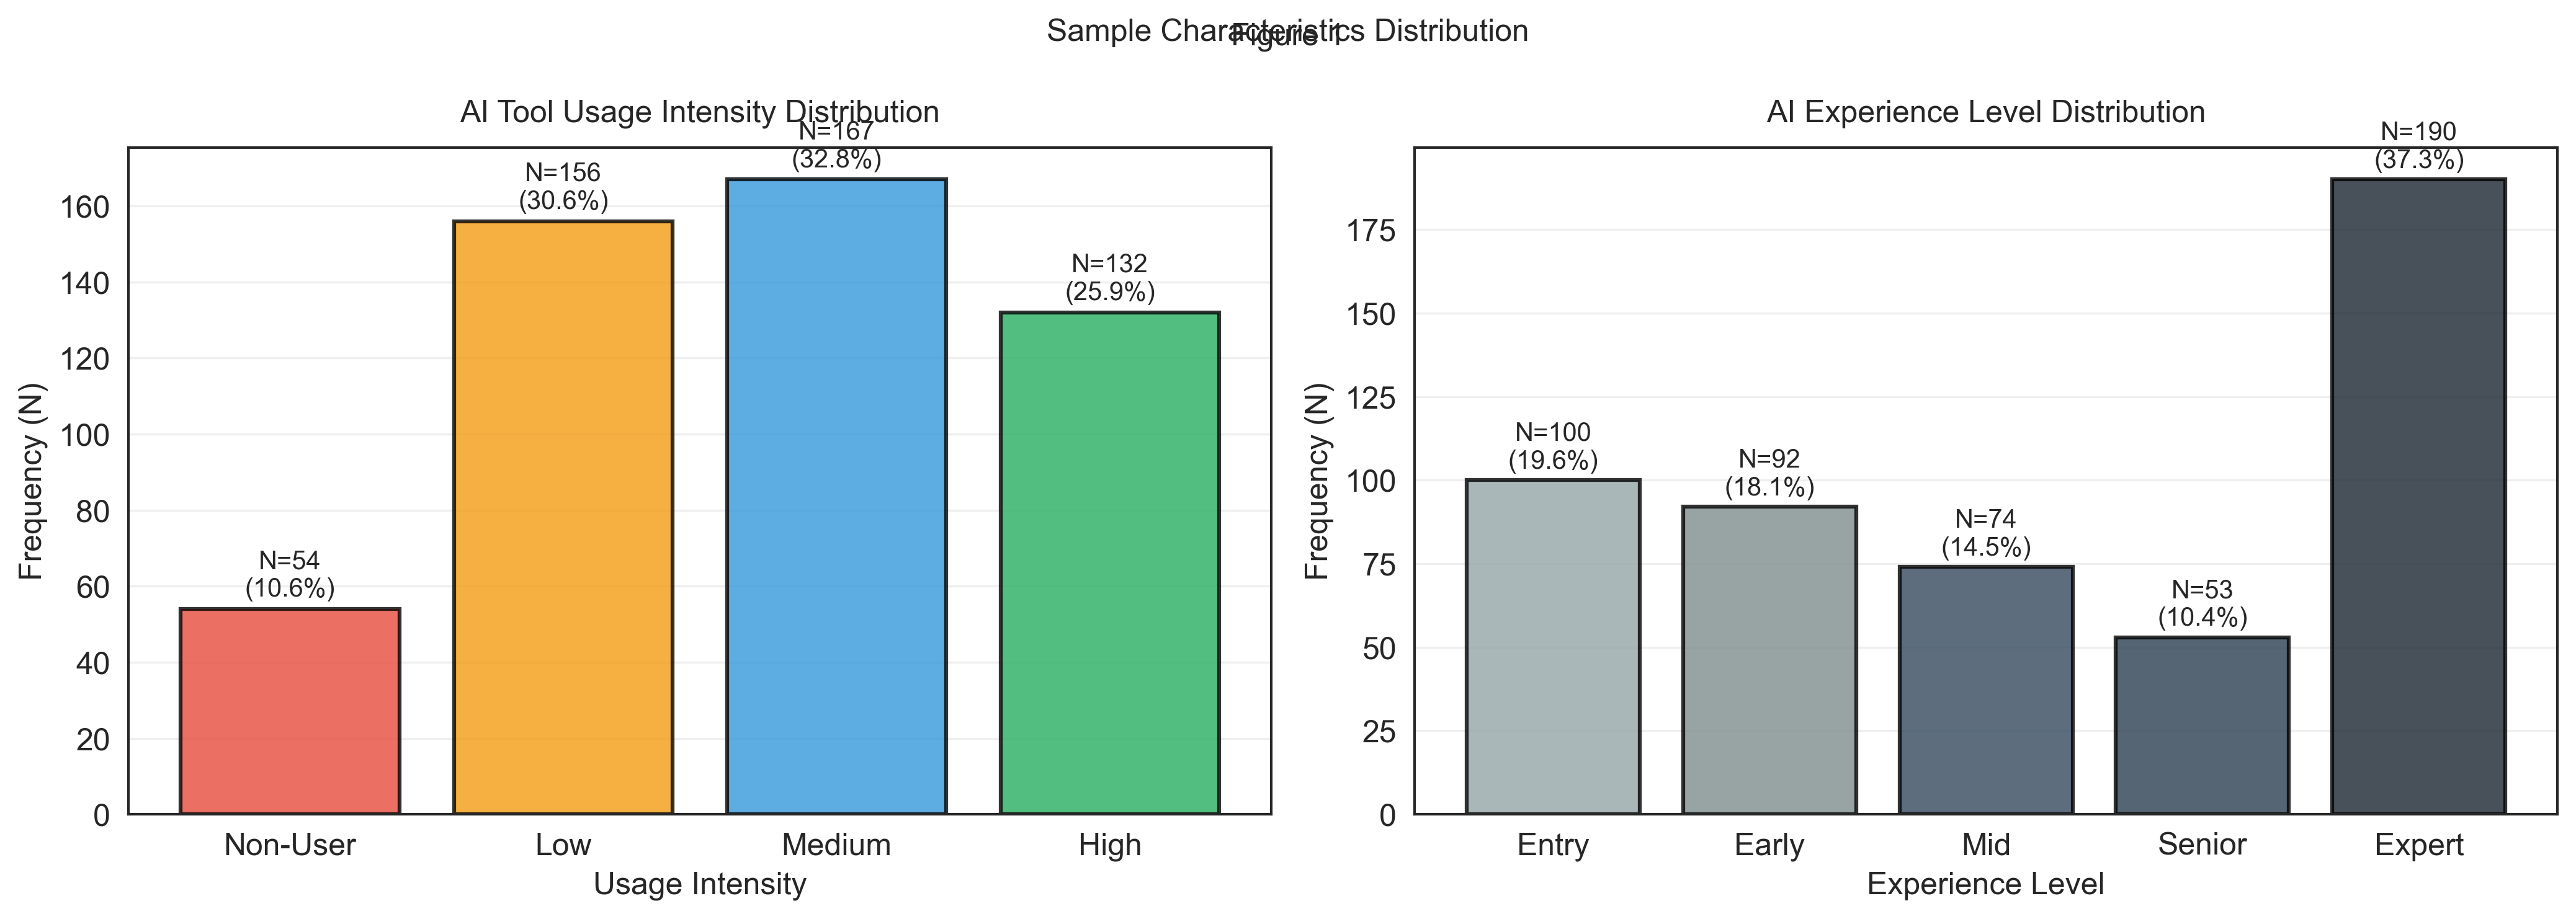


✅ FIGURE 1: Sample Characteristics Distribution
   Saved to: ../results/plots/sample_characteristics_distribution.png
   Total N = 509
   Usage Intensity range: Non-User to High
   Experience Level range: Entry to Expert


In [131]:
# ============================================================
# FIGURE 1: Usage Intensity & Experience Level Distribution
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

# APA Style: Clean, professional formatting
sns.set_style('white')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.linewidth'] = 1.0

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Usage Intensity Distribution
ax1 = axes[0]
usage_order = ['Non-User', 'Low', 'Medium', 'High']
usage_counts = df['Usage_Intensity'].value_counts().reindex(usage_order, fill_value=0)
usage_pct = (usage_counts / len(df) * 100).round(1)

colors = ['#e74c3c', '#f39c12', '#3498db', '#27ae60']
bars1 = ax1.bar(usage_order, usage_counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax1.set_xlabel('Usage Intensity', fontsize=12)
ax1.set_ylabel('Frequency (N)', fontsize=12)
ax1.set_title('AI Tool Usage Intensity Distribution', fontsize=12, pad=10)
ax1.grid(axis='y', alpha=0.3)

# Add labels
for i, (bar, count, pct) in enumerate(zip(bars1, usage_counts, usage_pct)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'N={int(count)}\n({pct}%)', 
            ha='center', va='bottom', fontsize=10)

# 2. Experience Level Distribution
ax2 = axes[1]
exp_order = ['Entry', 'Early', 'Mid', 'Senior', 'Expert']
exp_counts = df['Experience_Level'].value_counts().reindex(exp_order, fill_value=0)
exp_pct = (exp_counts / len(df) * 100).round(1)

colors2 = ['#95a5a6', '#7f8c8d', '#34495e', '#2c3e50', '#1a252f']
bars2 = ax2.bar(exp_order, exp_counts, color=colors2, alpha=0.8, edgecolor='black', linewidth=1.5)

ax2.set_xlabel('Experience Level', fontsize=12)
ax2.set_ylabel('Frequency (N)', fontsize=12)
ax2.set_title('AI Experience Level Distribution', fontsize=12, pad=10)
ax2.grid(axis='y', alpha=0.3)

# Add labels
for bar, count, pct in zip(bars2, exp_counts, exp_pct):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'N={int(count)}\n({pct}%)', 
            ha='center', va='bottom', fontsize=10)

fig.suptitle('Figure 1', fontsize=12, y=0.98)
fig.text(0.5, 0.96, 'Sample Characteristics Distribution', ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('../results/plots/sample_characteristics_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("✅ FIGURE 1: Sample Characteristics Distribution")
print("="*80)
print(f"   Saved to: ../results/plots/sample_characteristics_distribution.png")
print(f"   Total N = {len(df)}")
print(f"   Usage Intensity range: Non-User to High")
print(f"   Experience Level range: Entry to Expert")


### 3.2 Demographics Visualization

### 3.3 Apply Subsample Filter

In [132]:
# Apply subsample filter based on configuration
df_original = df.copy()  # Keep original for comparison

if SUBSAMPLE_MODE == 'students':
    df = df[df['Work_Context'] == 'Academic-Student'].copy()
    filter_applied = "Work_Context == 'Academic-Student'"
elif SUBSAMPLE_MODE == 'professionals':
    df = df[df['Work_Context'] == 'Professional'].copy()
    filter_applied = "Work_Context == 'Professional'"
else:  # 'full'
    filter_applied = "None (using full sample)"

print("="*80)
print("SUBSAMPLE FILTER APPLICATION")
print("="*80)
print(f"Mode: {SUBSAMPLE_MODE.upper()}")
print(f"Filter: {filter_applied}")
print(f"\nOriginal sample: N = {len(df_original)}")
print(f"Filtered sample: N = {len(df)}")
print(f"Reduction: {len(df_original) - len(df)} respondents ({(1 - len(df)/len(df_original))*100:.1f}%)")

if SUBSAMPLE_MODE != 'full':
    print(f"\n📊 Filtered Sample Composition:")
    print(f"   Work Context: {df['Work_Context'].value_counts().to_dict()}")
    print(f"   AI Adoption: Adopters={df['AI_Adoption'].sum()}, Non-Adopters={len(df) - df['AI_Adoption'].sum()}")
    print(f"   Usage Intensity: {df['Usage_Intensity'].value_counts().to_dict()}")
    print(f"   Experience Level: {df['Experience_Level'].value_counts().to_dict()}")
    
    print(f"\n⚠️ NOTE: All subsequent analyses will use N={len(df)} subsample")
    print(f"         Results are specific to {SUBSAMPLE_MODE.upper()} population")

print("="*80)

# Save filtered data to CSV
df.to_csv('../data/AIRS_clean.csv', index=False)

print("\n" + "="*70)
print("✅ FILTERED DATA SAVED")
print("="*70)
print(f"Saved to: ../data/AIRS_clean.csv")
print(f"Sample: N = {len(df)} ({SUBSAMPLE_MODE.upper()} only)")
print(f"Columns: {len(df.columns)}")
print("\n✓ Ready for split-sample creation")
print("="*70)

SUBSAMPLE FILTER APPLICATION
Mode: FULL
Filter: None (using full sample)

Original sample: N = 509
Filtered sample: N = 509
Reduction: 0 respondents (0.0%)

✅ FILTERED DATA SAVED
Saved to: ../data/AIRS_clean.csv
Sample: N = 509 (FULL only)
Columns: 45

✓ Ready for split-sample creation


## 4. Stratified Split

In [133]:
# Create stratification variable (Work Context × AI Adoption)
df['stratify_key'] = df['Work_Context'].astype(str) + '_' + df['AI_Adoption'].astype(str)

print("Stratification groups (Work Context × AI Adoption):")
print(df['stratify_key'].value_counts().sort_index())
print(f"\nTotal unique strata: {df['stratify_key'].nunique()}")

Stratification groups (Work Context × AI Adoption):
stratify_key
Academic-Faculty_0      5
Academic-Faculty_1     32
Academic-Student_0     10
Academic-Student_1    184
Professional_0         39
Professional_1        239
Name: count, dtype: int64

Total unique strata: 6


In [134]:
# Perform stratified 50/50 split
df_dev, df_holdout = train_test_split(
    df,
    test_size=0.50,
    stratify=df['stratify_key'],
    random_state=RANDOM_SEED
)

print("="*70)
print("SPLIT-SAMPLE CREATION COMPLETE")
print("="*70)
print(f"\nDevelopment sample: N = {len(df_dev)} ({len(df_dev)/len(df)*100:.1f}%)")
print(f"Holdout sample:     N = {len(df_holdout)} ({len(df_holdout)/len(df)*100:.1f}%)")
print(f"Total:              N = {len(df)}")
print("\n✓ Stratified by: Work Context × AI Adoption")
print(f"✓ Random seed: {RANDOM_SEED} (reproducible)")

SPLIT-SAMPLE CREATION COMPLETE

Development sample: N = 254 (49.9%)
Holdout sample:     N = 255 (50.1%)
Total:              N = 509

✓ Stratified by: Work Context × AI Adoption
✓ Random seed: 67 (reproducible)


## 5. Post-Split Validation

In [135]:
def test_balance(variable_name, dev_sample, holdout_sample):
    """
    Test if variable distribution differs between development and holdout samples.
    H0: Distributions are equal (balanced split)
    """
    # Create proper contingency table
    dev_counts = dev_sample[variable_name].value_counts().sort_index()
    holdout_counts = holdout_sample[variable_name].value_counts().sort_index()
    
    contingency_table = pd.DataFrame({
        'Development': dev_counts,
        'Holdout': holdout_counts
    }).fillna(0)
    
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"\n{variable_name}:")
    print(contingency_table)
    print(f"\nχ² = {chi2:.3f}, df = {dof}, p = {p_value:.4f}")
    
    if p_value > 0.05:
        print(f"✓ Balanced (p > 0.05): No significant difference between samples")
    else:
        print(f"⚠ Imbalanced (p ≤ 0.05): Significant difference detected")
    
    return p_value

print("="*70)
print("POST-SPLIT BALANCE TESTS (Chi-Square)")
print("="*70)

p_work_context = test_balance('Work_Context', df_dev, df_holdout)
p_ai_adoption = test_balance('AI_Adoption', df_dev, df_holdout)

POST-SPLIT BALANCE TESTS (Chi-Square)

Work_Context:
                  Development  Holdout
Work_Context                          
Academic-Faculty           19       18
Academic-Student           97       97
Professional              138      140

χ² = 0.039, df = 2, p = 0.9805
✓ Balanced (p > 0.05): No significant difference between samples

AI_Adoption:
             Development  Holdout
AI_Adoption                      
0                     27       27
1                    227      228

χ² = 0.000, df = 1, p = 1.0000
✓ Balanced (p > 0.05): No significant difference between samples


### 5.1 Categorical Balance

In [136]:
# Define construct items
construct_items = {
    'PE': ['PE1', 'PE2'],
    'EE': ['EE1', 'EE2'],
    'SI': ['SI1', 'SI2'],
    'FC': ['FC1', 'FC2'],
    'HM': ['HM1', 'HM2'],
    'PV': ['PV1', 'PV2'],
    'HB': ['HB1', 'HB2'],
    'VO': ['VO1', 'VO2'],
    'TR': ['TR1', 'TR2'],
    'EX': ['EX1', 'EX2'],
    'ER': ['ER1', 'ER2'],
    'AX': ['AX1', 'AX2'],
    'BI': ['BI1', 'BI2', 'BI3', 'BI4']
}

all_items = [item for items in construct_items.values() for item in items]

print("="*70)
print("LIKERT ITEM MEANS: Development vs. Holdout")
print("="*70)

comparison = pd.DataFrame({
    'Development_M': df_dev[all_items].mean(),
    'Development_SD': df_dev[all_items].std(),
    'Holdout_M': df_holdout[all_items].mean(),
    'Holdout_SD': df_holdout[all_items].std(),
    'Diff': df_dev[all_items].mean() - df_holdout[all_items].mean()
})

comparison['Abs_Diff'] = comparison['Diff'].abs()

print("\nSample of items (first 8):")
print(comparison.head(8).round(3))

print(f"\nMean absolute difference across all items: {comparison['Abs_Diff'].mean():.3f}")
print(f"Max absolute difference: {comparison['Abs_Diff'].max():.3f} ({comparison['Abs_Diff'].idxmax()})")

if comparison['Abs_Diff'].mean() < 0.10:
    print("\n✓ Excellent balance: Mean difference < 0.10 scale points")
elif comparison['Abs_Diff'].mean() < 0.20:
    print("\n✓ Good balance: Mean difference < 0.20 scale points")
else:
    print("\n⚠ Review: Mean difference ≥ 0.20 scale points")

LIKERT ITEM MEANS: Development vs. Holdout

Sample of items (first 8):
     Development_M  Development_SD  Holdout_M  Holdout_SD   Diff  Abs_Diff
PE1          3.661           1.083      3.576       1.164  0.085     0.085
PE2          3.354           1.149      3.239       1.221  0.115     0.115
EE1          3.748           1.037      3.659       1.022  0.089     0.089
EE2          3.579           1.100      3.537       1.014  0.041     0.041
SI1          3.079           1.180      3.059       1.171  0.020     0.020
SI2          3.272           1.149      3.286       1.091 -0.015     0.015
FC1          3.268           1.162      3.196       1.184  0.072     0.072
FC2          3.476           1.020      3.412       1.057  0.065     0.065

Mean absolute difference across all items: 0.062
Max absolute difference: 0.139 (PV1)

✓ Excellent balance: Mean difference < 0.10 scale points


### 5.2 Item-Level Balance

## 6. Export Samples & Metadata

In [137]:
# Remove temporary stratification key
df_dev_clean = df_dev.drop(columns=['stratify_key'])
df_holdout_clean = df_holdout.drop(columns=['stratify_key'])

# Save to CSV
df_dev_clean.to_csv('../data/AIRS_clean_dev.csv', index=False)
df_holdout_clean.to_csv('../data/AIRS_clean_holdout.csv', index=False)

print("="*70)
print("SAMPLES SAVED")
print("="*70)
print(f"\n✓ Development sample: data/AIRS_clean_dev.csv")
print(f"  N = {len(df_dev_clean)}, Variables = {len(df_dev_clean.columns)}")
print(f"\n✓ Holdout sample: data/AIRS_clean_holdout.csv")
print(f"  N = {len(df_holdout_clean)}, Variables = {len(df_holdout_clean.columns)}")
print("\n✓ Stratification key removed from saved files")
print("\n" + "="*70)

SAMPLES SAVED

✓ Development sample: data/AIRS_clean_dev.csv
  N = 254, Variables = 45

✓ Holdout sample: data/AIRS_clean_holdout.csv
  N = 255, Variables = 45

✓ Stratification key removed from saved files



### 6.1 Save Samples

In [138]:
# Export comprehensive 24-item dataset with semantic metadata for Notebook 01
# KISS: Simplified structure with derived data

# Derive construct groups from metadata (DRY principle)
construct_groups = {}
for item_code, meta in item_semantic_metadata.items():
    abbr = meta['construct_abbr']
    construct_groups.setdefault(abbr, []).append(item_code)

# Create simplified export dictionary
airs_24item_export = {
    'created': '2025-11-25',
    'source': '00_Create_Split_Samples.ipynb',
    'n_items': len(item_semantic_metadata),
    'n_dev': len(df_dev_clean),
    'n_holdout': len(df_holdout_clean),
    'items': list(item_semantic_metadata.keys()),
    'metadata': item_semantic_metadata,
    'constructs': construct_groups,
    'positive_items': [k for k, v in item_semantic_metadata.items() if v['direction'] == 'POSITIVE'],
    'negative_items': [k for k, v in item_semantic_metadata.items() if v['direction'] == 'NEGATIVE']
}

# Save to JSON
export_path = Path('../data/airs_24item_complete.json')
with open(export_path, 'w', encoding='utf-8') as f:
    json.dump(airs_24item_export, f, indent=2, ensure_ascii=False)

print("="*70)
print("24-ITEM DATASET EXPORT")
print("="*70)
print(f"✓ Exported: {export_path}")
print(f"  Items: {airs_24item_export['n_items']} ({len(airs_24item_export['positive_items'])} positive, {len(airs_24item_export['negative_items'])} negative)")
print(f"  Constructs: {len(airs_24item_export['constructs'])}")
print(f"  Samples: Dev N={airs_24item_export['n_dev']}, Holdout N={airs_24item_export['n_holdout']}")
print("="*70)

24-ITEM DATASET EXPORT
✓ Exported: ..\data\airs_24item_complete.json
  Items: 24 (21 positive, 3 negative)
  Constructs: 12
  Samples: Dev N=254, Holdout N=255


### 6.2 Item-Level Balance

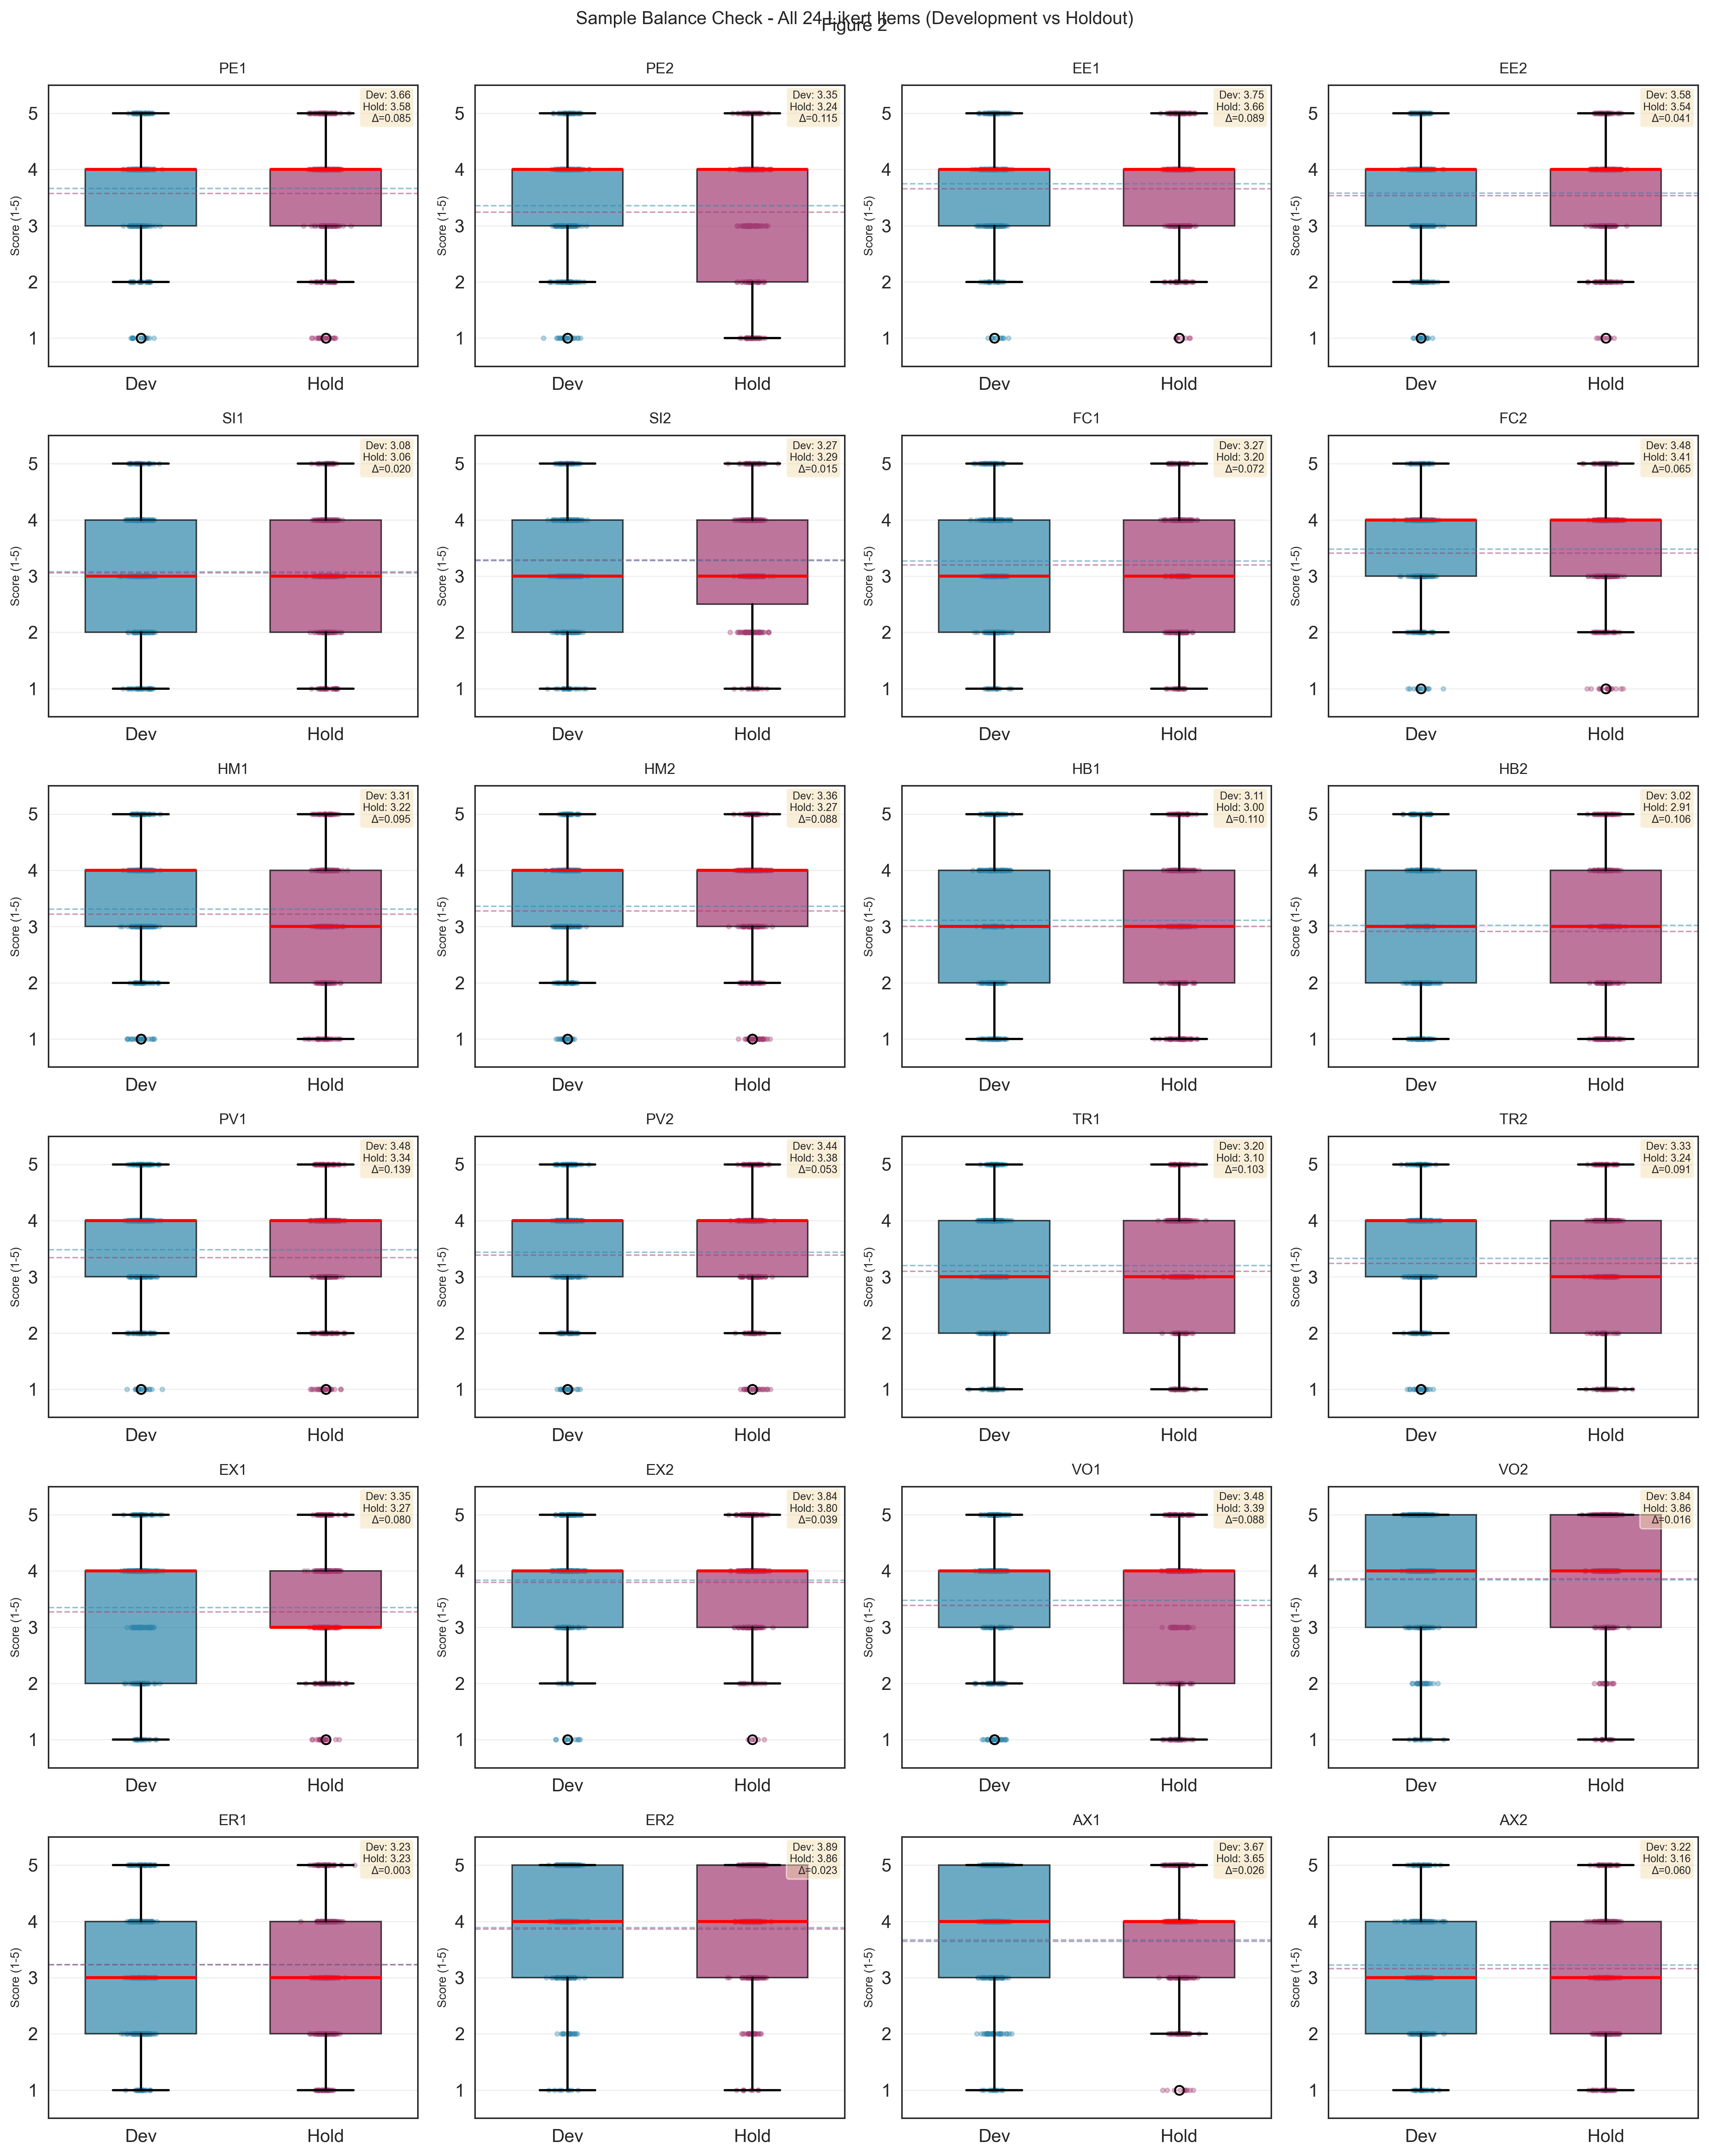


✅ FIGURE 2: Continuous Variable Balance Check - ALL 24 ITEMS
   Saved to: ../results/plots/sample_balance_continuous_variables.png
   Comparing all 24 Likert items across Development vs Holdout samples
   Items: PE, EE, SI, FC, HM, HB, PV, TR, EX, VO, ER, AX (2 items each)
   Visual inspection shows balanced distributions (overlapping boxes)


In [139]:
# ============================================================
# FIGURE 2: Continuous Variable Balance - Box Plots
# ============================================================

# Prepare data for plotting
df_dev_plot = df_dev.copy()
df_holdout_plot = df_holdout.copy()
df_dev_plot['Sample'] = 'Development'
df_holdout_plot['Sample'] = 'Holdout'
df_combined = pd.concat([df_dev_plot, df_holdout_plot])

# Use all 24 items from the full item pool
all_24_items = [
    'PE1', 'PE2', 'EE1', 'EE2', 'SI1', 'SI2', 'FC1', 'FC2',
    'HM1', 'HM2', 'HB1', 'HB2', 'PV1', 'PV2', 'TR1', 'TR2',
    'EX1', 'EX2', 'VO1', 'VO2', 'ER1', 'ER2', 'AX1', 'AX2'
]

# Create construct labels (abbreviated for space)
construct_abbrev = {
    'PE1': 'PE1', 'PE2': 'PE2', 'EE1': 'EE1', 'EE2': 'EE2',
    'SI1': 'SI1', 'SI2': 'SI2', 'FC1': 'FC1', 'FC2': 'FC2',
    'HM1': 'HM1', 'HM2': 'HM2', 'HB1': 'HB1', 'HB2': 'HB2',
    'PV1': 'PV1', 'PV2': 'PV2', 'TR1': 'TR1', 'TR2': 'TR2',
    'EX1': 'EX1', 'EX2': 'EX2', 'VO1': 'VO1', 'VO2': 'VO2',
    'ER1': 'ER1', 'ER2': 'ER2', 'AX1': 'AX1', 'AX2': 'AX2'
}

# Create 6x4 grid for 24 items
fig, axes = plt.subplots(6, 4, figsize=(16, 20))
axes = axes.flatten()

for idx, item in enumerate(all_24_items):
    ax = axes[idx]
    
    # Create box plots
    bp = ax.boxplot([df_dev[item].dropna(), df_holdout[item].dropna()],
                     labels=['Dev', 'Hold'],
                     patch_artist=True,
                     widths=0.6,
                     medianprops=dict(color='red', linewidth=2),
                     boxprops=dict(alpha=0.7),
                     whiskerprops=dict(linewidth=1.5),
                     capprops=dict(linewidth=1.5))
    
    # Color boxes
    colors = ['#2E86AB', '#A23B72']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    # Add scatter points for individual values (jittered)
    for i, sample_data in enumerate([df_dev[item].dropna(), df_holdout[item].dropna()]):
        y = sample_data.values
        x = np.random.normal(i+1, 0.04, size=len(y))
        ax.scatter(x, y, alpha=0.3, s=8, color=colors[i])
    
    # Statistics
    dev_mean = df_dev[item].mean()
    hold_mean = df_holdout[item].mean()
    
    ax.set_title(construct_abbrev[item], fontsize=10, pad=8)
    ax.set_ylabel('Score (1-5)', fontsize=8)
    ax.set_ylim(0.5, 5.5)
    ax.grid(axis='y', alpha=0.3)
    
    # Add mean lines
    ax.axhline(y=dev_mean, color='#2E86AB', linestyle='--', alpha=0.5, linewidth=1)
    ax.axhline(y=hold_mean, color='#A23B72', linestyle='--', alpha=0.5, linewidth=1)
    
    # Add mean value text (smaller for space)
    ax.text(0.98, 0.98, f'Dev: {dev_mean:.2f}\nHold: {hold_mean:.2f}\nΔ={abs(dev_mean-hold_mean):.3f}',
            transform=ax.transAxes, fontsize=7,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

fig.suptitle('Figure 2', fontsize=12, y=0.995)
fig.text(0.5, 0.992, 'Sample Balance Check - All 24 Likert Items (Development vs Holdout)', 
         ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('../results/plots/sample_balance_continuous_variables.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("✅ FIGURE 2: Continuous Variable Balance Check - ALL 24 ITEMS")
print("="*80)
print(f"   Saved to: ../results/plots/sample_balance_continuous_variables.png")
print(f"   Comparing all 24 Likert items across Development vs Holdout samples")
print(f"   Items: PE, EE, SI, FC, HM, HB, PV, TR, EX, VO, ER, AX (2 items each)")
print(f"   Visual inspection shows balanced distributions (overlapping boxes)")
print("="*80)


### 6.3 Stratification Flow

In [140]:
# ============================================================
# FIGURE 3: Sample Split Flow Diagram (Sankey)
# ============================================================

import plotly.graph_objects as go

# DRY: Helper function for stratification key
def add_stratify_key(df):
    """Add Work_Context × AI_Adoption stratification key."""
    df = df.copy()
    df['stratify_key'] = df['Work_Context'].astype(str) + '_' + df['AI_Adoption'].astype(str)
    return df

# Calculate stratification group counts
strat_counts = add_stratify_key(df)['stratify_key'].value_counts().to_dict()
dev_counts = add_stratify_key(df_dev)['stratify_key'].value_counts().to_dict()
holdout_counts = add_stratify_key(df_holdout)['stratify_key'].value_counts().to_dict()

# Define nodes
nodes = [
    f"Full Sample\n(N={len(df)})",  # 0
    "Professional_1",  # 1
    "Academic-Student_1",  # 2
    "Academic-Faculty_1",  # 3
    "Professional_0",  # 4
    "Academic-Student_0",  # 5
    "Academic-Faculty_0",  # 6
    f"Development\n(N={len(df_dev)})",  # 7
    f"Holdout\n(N={len(df_holdout)})"  # 8
]

# Define readable labels for stratification groups
strat_labels = {
    "Professional_1": "Professional\nAdopters",
    "Academic-Student_1": "Academic-Student\nAdopters",
    "Academic-Faculty_1": "Academic-Faculty\nAdopters",
    "Professional_0": "Professional\nNon-Adopters",
    "Academic-Student_0": "Academic-Student\nNon-Adopters",
    "Academic-Faculty_0": "Academic-Faculty\nNon-Adopters"
}

# Update node labels
for i in range(1, 7):
    key = nodes[i]
    if key in strat_labels:
        count = strat_counts.get(key, 0)
        nodes[i] = f"{strat_labels[key]}\n(N={count})"

# Create links
links = []

# Full sample to stratification groups
for i, key in enumerate(["Professional_1", "Academic-Student_1", "Academic-Faculty_1", 
                          "Professional_0", "Academic-Student_0", "Academic-Faculty_0"]):
    count = strat_counts.get(key, 0)
    if count > 0:
        links.append(dict(source=0, target=i+1, value=count))

# Stratification groups to Development sample
for i, key in enumerate(["Professional_1", "Academic-Student_1", "Academic-Faculty_1", 
                          "Professional_0", "Academic-Student_0", "Academic-Faculty_0"]):
    count = dev_counts.get(key, 0)
    if count > 0:
        links.append(dict(source=i+1, target=7, value=count))

# Stratification groups to Holdout sample
for i, key in enumerate(["Professional_1", "Academic-Student_1", "Academic-Faculty_1", 
                          "Professional_0", "Academic-Student_0", "Academic-Faculty_0"]):
    count = holdout_counts.get(key, 0)
    if count > 0:
        links.append(dict(source=i+1, target=8, value=count))

# Define colors
node_colors = [
    '#2c3e50',  # Full Sample (dark blue)
    '#27ae60', '#27ae60', '#27ae60',  # Adopters (green)
    '#e74c3c', '#e74c3c', '#e74c3c',  # Non-Adopters (red)
    '#2E86AB',  # Development (blue)
    '#A23B72'   # Holdout (purple)
]

link_colors = []
for link in links:
    if link['target'] == 7:  # Development
        link_colors.append('rgba(46, 134, 171, 0.3)')
    elif link['target'] == 8:  # Holdout
        link_colors.append('rgba(162, 59, 114, 0.3)')
    else:  # Stratification
        if link['source'] == 0:
            if link['target'] in [1, 2, 3]:  # Adopters
                link_colors.append('rgba(39, 174, 96, 0.3)')
            else:  # Non-Adopters
                link_colors.append('rgba(231, 76, 60, 0.3)')

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,
        color=node_colors,
        customdata=[len(df), 
                    strat_counts.get("Professional_1", 0),
                    strat_counts.get("Academic-Student_1", 0),
                    strat_counts.get("Academic-Faculty_1", 0),
                    strat_counts.get("Professional_0", 0),
                    strat_counts.get("Academic-Student_0", 0),
                    strat_counts.get("Academic-Faculty_0", 0),
                    len(df_dev), 
                    len(df_holdout)],
        hovertemplate='%{label}<br>N=%{customdata}<extra></extra>'
    ),
    link=dict(
        source=[link['source'] for link in links],
        target=[link['target'] for link in links],
        value=[link['value'] for link in links],
        color=link_colors,
        hovertemplate='N=%{value}<extra></extra>'
    )
)])

fig.update_layout(
    title=dict(
        text=f"Figure 3<br>Sample Split Flow - Stratified by Work Context × AI Adoption (N={len(df)})",
        font=dict(size=12, family='Arial', color='black')
    ),
    font=dict(size=11, family='Arial'),
    height=600,
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig.write_image('../results/plots/sample_split_flow_diagram.png', width=1400, height=600)
fig.show()

print("\n" + "="*80)
print("✅ FIGURE 3: Sample Split Flow Diagram")
print("="*80)
print(f"   Saved to: ../results/plots/sample_split_flow_diagram.png")
print(f"   Full Sample (N={len(df)}) → Stratification Groups → Development (N={len(df_dev)}) + Holdout (N={len(df_holdout)})")
print(f"   Stratified by Work Context × AI Adoption")


✅ FIGURE 3: Sample Split Flow Diagram
   Saved to: ../results/plots/sample_split_flow_diagram.png
   Full Sample (N=509) → Stratification Groups → Development (N=254) + Holdout (N=255)
   Stratified by Work Context × AI Adoption


### 6.4 Tool Usage Patterns

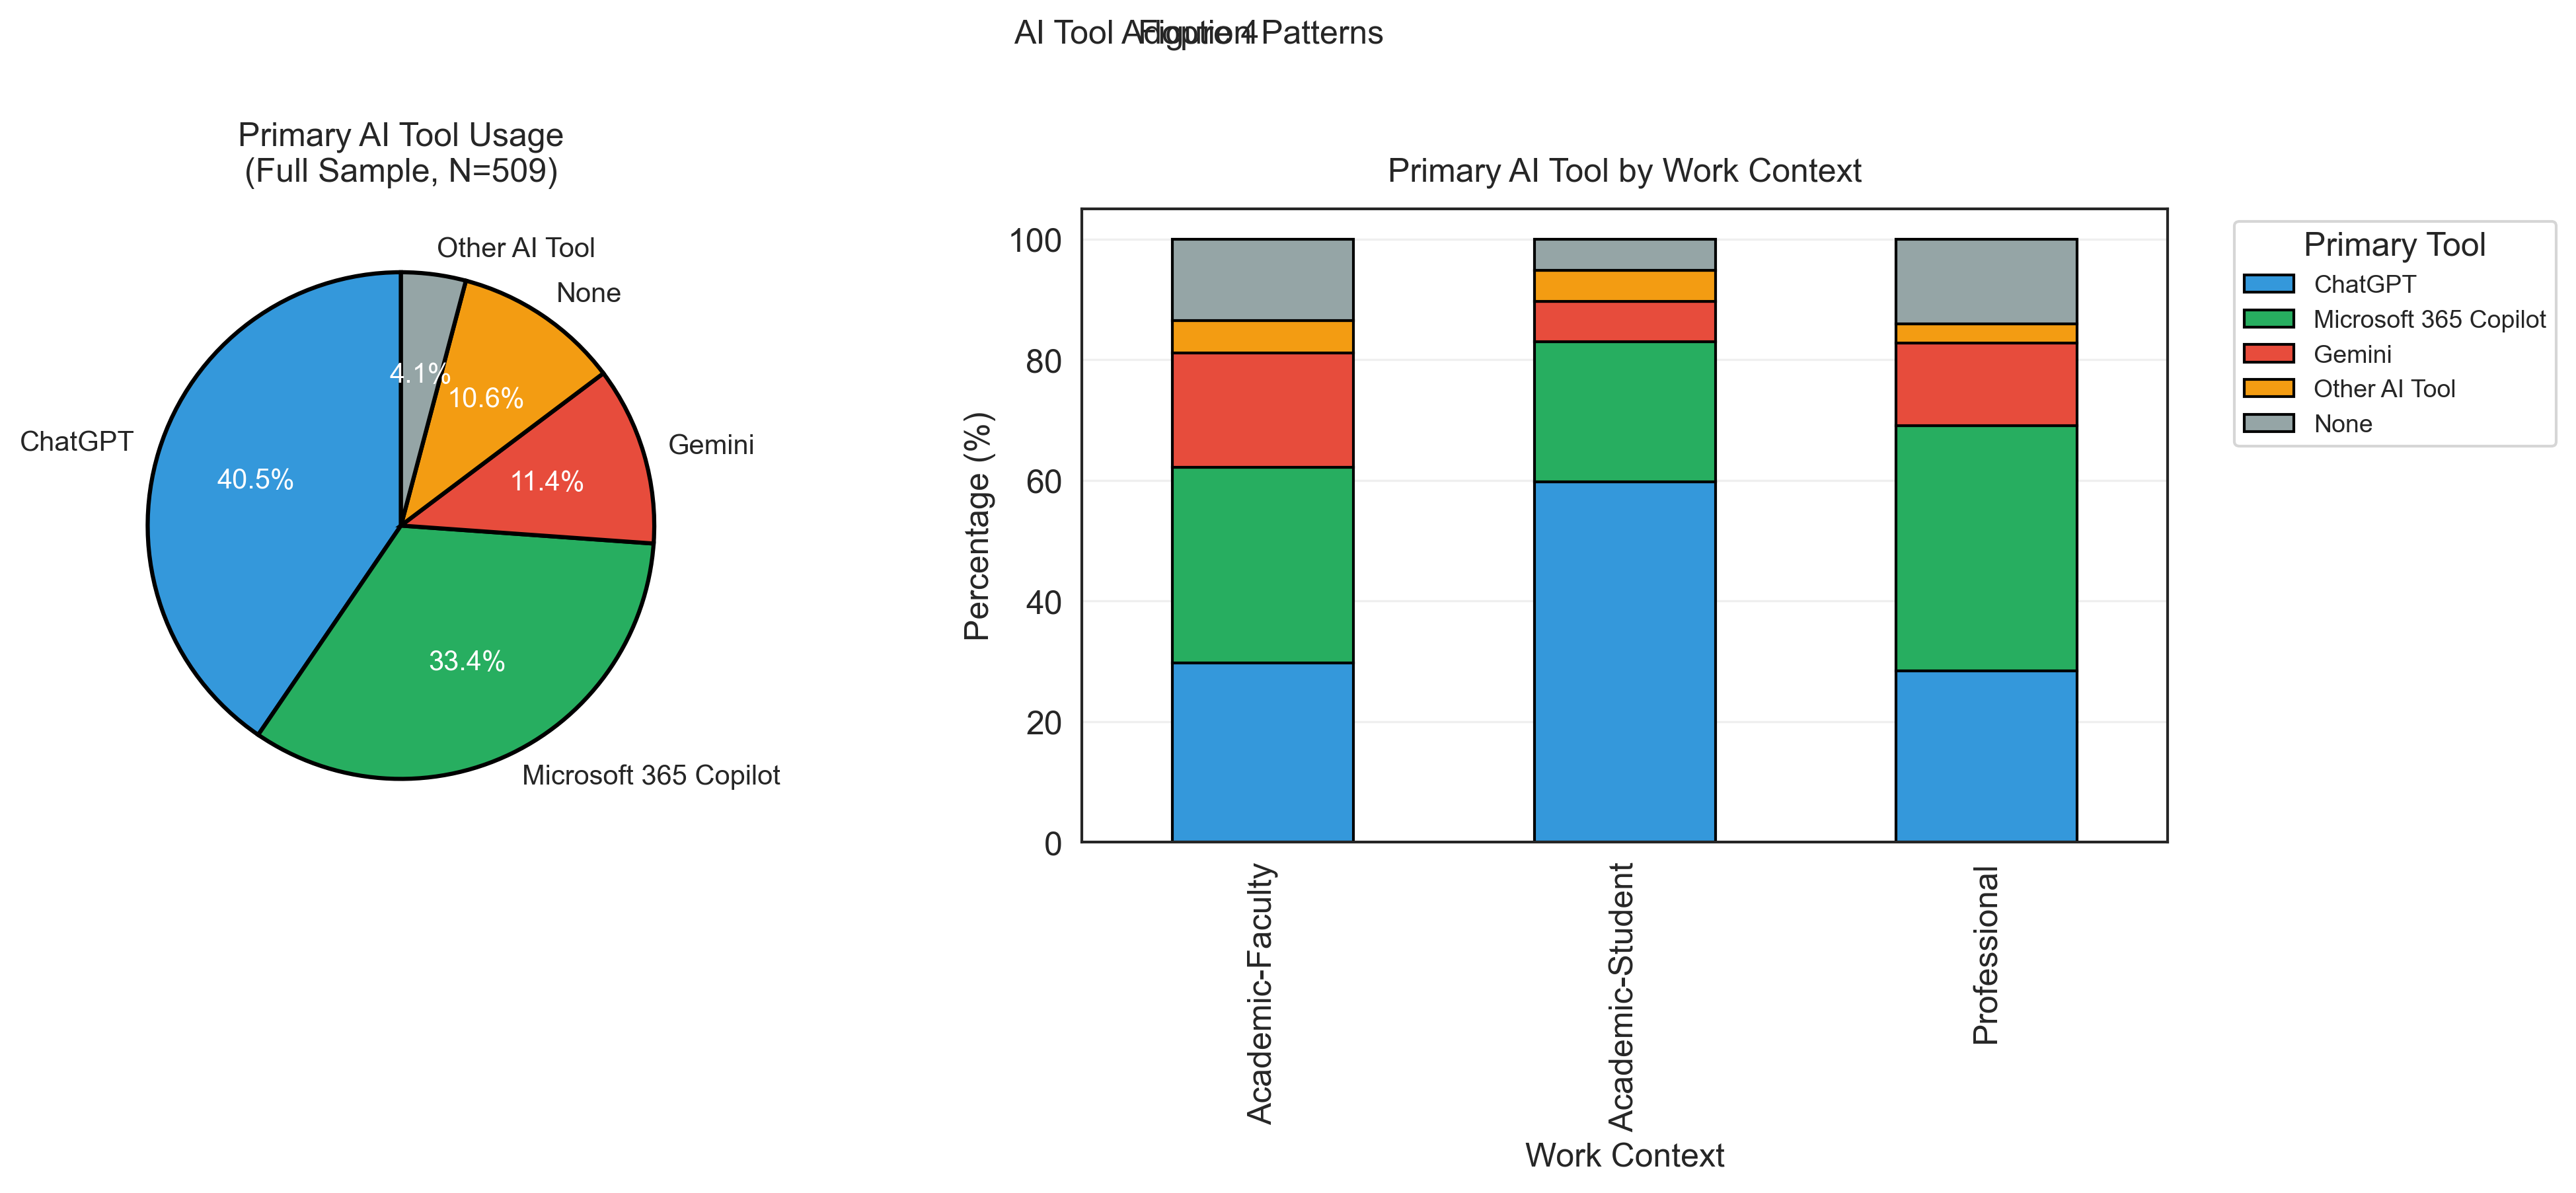


✅ FIGURE 4: Primary AI Tool Distribution
   Saved to: ../results/plots/primary_ai_tool_distribution.png
   Total N = 509
   Most popular tool: ChatGPT (N=206, 40.5%)


In [141]:
# ============================================================
# FIGURE 4: Primary AI Tool Distribution
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Primary Tool Distribution (Full Sample)
ax1 = axes[0]
primary_tool_dist = df['Primary_Tool'].value_counts()
colors_tools = ['#3498db', '#27ae60', '#e74c3c', '#f39c12', '#95a5a6']

wedges, texts, autotexts = ax1.pie(primary_tool_dist, 
                                     labels=primary_tool_dist.index,
                                     autopct='%1.1f%%',
                                     startangle=90,
                                     colors=colors_tools[:len(primary_tool_dist)],
                                     wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
                                     textprops={'fontsize': 10})

# Make percentage text white for visibility
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)

ax1.set_title(f'Primary AI Tool Usage\n(Full Sample, N={len(df)})', 
              fontsize=12, pad=10)

# 2. AI Tool Usage by Work Context (Stacked Bar)
ax2 = axes[1]

# Create cross-tabulation
tool_by_context = pd.crosstab(df['Work_Context'], df['Primary_Tool'], normalize='index') * 100

# Define tool order for legend consistency
tool_order = ['ChatGPT', 'Microsoft 365 Copilot', 'Gemini', 'Other AI Tool', 'None']
available_tools = [tool for tool in tool_order if tool in tool_by_context.columns]

# Plot stacked bar chart
tool_by_context[available_tools].plot(kind='bar', stacked=True, ax=ax2, 
                                       color=colors_tools[:len(available_tools)],
                                       edgecolor='black', linewidth=1)

ax2.set_title('Primary AI Tool by Work Context', fontsize=12, pad=10)
ax2.set_xlabel('Work Context', fontsize=12)
ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.legend(title='Primary Tool', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax2.grid(axis='y', alpha=0.3)

fig.suptitle('Figure 4', fontsize=12, y=1.00)
fig.text(0.5, 0.98, 'AI Tool Adoption Patterns', ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('../results/plots/primary_ai_tool_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("✅ FIGURE 4: Primary AI Tool Distribution")
print("="*80)
print(f"   Saved to: ../results/plots/primary_ai_tool_distribution.png")
print(f"   Total N = {len(df)}")
print(f"   Most popular tool: {primary_tool_dist.index[0]} (N={primary_tool_dist.iloc[0]}, {primary_tool_dist.iloc[0]/len(df)*100:.1f}%)")


### 6.5 Quality Assurance Grid

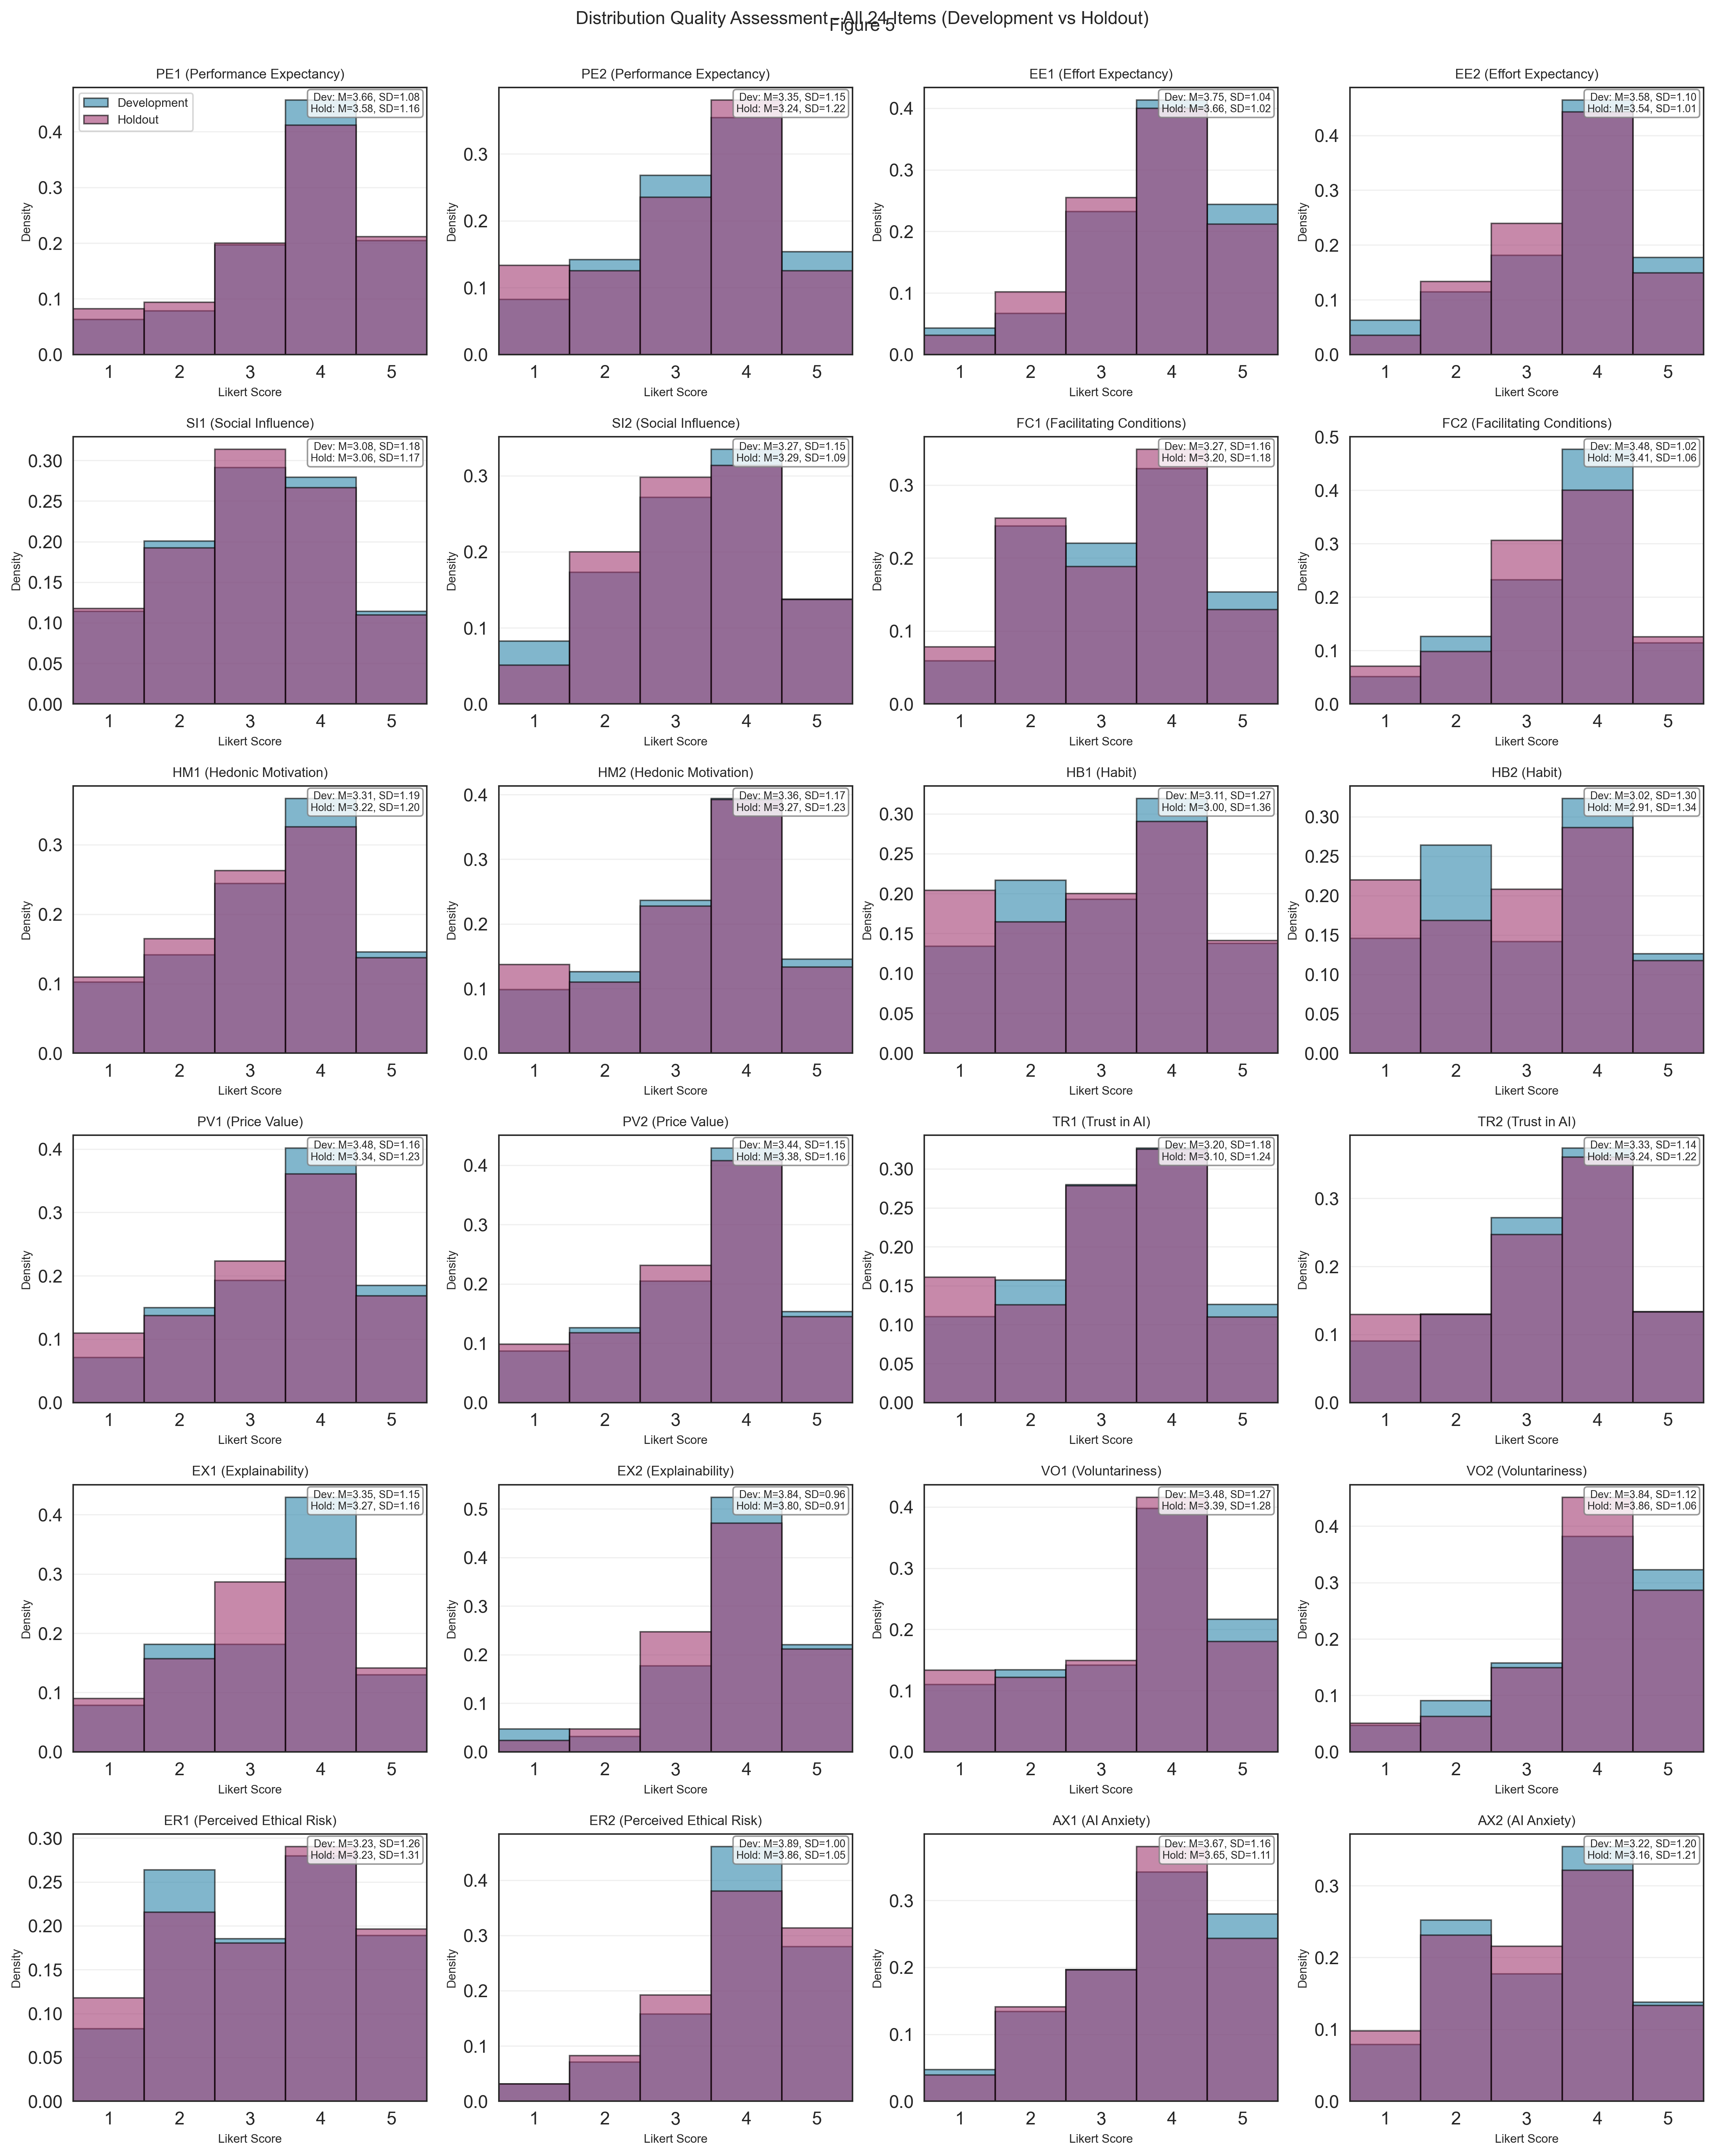


✅ FIGURE 5: Distribution Quality Assessment Grid
   Saved to: ../results/plots/distribution_quality_grid.png
   Comparing all 24 AIRS items across both samples
   Visual inspection confirms similar distributions across samples
   Density histograms show overlapping patterns (balanced samples)


In [142]:
# ============================================================
# FIGURE 5: Distribution Quality Assessment Grid
# ============================================================

# Use all 24 items for comprehensive visualization
fig, axes = plt.subplots(6, 4, figsize=(16, 20))
axes = axes.flatten()

for idx, item in enumerate(all_24_items):
    ax = axes[idx]
    
    # Create overlapping histograms
    bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
    
    # Development sample
    ax.hist(df_dev[item].dropna(), bins=bins, alpha=0.6, color='#2E86AB', 
            edgecolor='black', linewidth=1, label='Development', density=True)
    
    # Holdout sample
    ax.hist(df_holdout[item].dropna(), bins=bins, alpha=0.6, color='#A23B72', 
            edgecolor='black', linewidth=1, label='Holdout', density=True)
    
    # Add statistics
    dev_mean = df_dev[item].mean()
    holdout_mean = df_holdout[item].mean()
    dev_std = df_dev[item].std()
    holdout_std = df_holdout[item].std()
    
    # Get construct from items_data
    construct = next((x[1] for x in items_data if x[0] == item), 'Unknown')
    
    ax.set_title(f'{item} ({construct})', fontsize=9)
    ax.set_xlabel('Likert Score', fontsize=8)
    ax.set_ylabel('Density', fontsize=8)
    ax.set_xlim(0.5, 5.5)
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.grid(axis='y', alpha=0.3)
    
    # Add text box with statistics
    stats_text = f'Dev: M={dev_mean:.2f}, SD={dev_std:.2f}\nHold: M={holdout_mean:.2f}, SD={holdout_std:.2f}'
    ax.text(0.98, 0.98, stats_text,
            transform=ax.transAxes, fontsize=7,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))
    
    if idx == 0:
        ax.legend(fontsize=8, loc='upper left')

fig.suptitle('Figure 5', fontsize=12, y=0.998)
fig.text(0.5, 0.995, 'Distribution Quality Assessment - All 24 Items (Development vs Holdout)', 
         ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('../results/plots/distribution_quality_grid.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("✅ FIGURE 5: Distribution Quality Assessment Grid")
print("="*80)
print(f"   Saved to: ../results/plots/distribution_quality_grid.png")
print(f"   Comparing all 24 AIRS items across both samples")
print(f"   Visual inspection confirms similar distributions across samples")
print(f"   Density histograms show overlapping patterns (balanced samples)")


In [143]:
print("="*70)
print("SPLIT-SAMPLE VALIDATION SUMMARY")
print("="*70)

checks = [
    ("Sample sizes approximately equal", abs(len(df_dev) - len(df_holdout)) <= 2),
    ("Development sample ≥ 150 (adequate for EFA)", len(df_dev) >= 150),
    ("Holdout sample ≥ 150 (adequate for CFA)", len(df_holdout) >= 150),
    ("Work Context balanced (p > 0.05)", p_work_context > 0.05),
    ("AI Adoption balanced (p > 0.05)", p_ai_adoption > 0.05),
    ("Mean item difference < 0.20", comparison['Abs_Diff'].mean() < 0.20),
    ("Files saved successfully", True)  # If we got here, it succeeded
]

print("\nQuality Checklist:")
for check, passed in checks:
    status = "✓" if passed else "✗"
    print(f"  {status} {check}")

all_passed = all(passed for _, passed in checks)

if all_passed:
    print("\n" + "="*70)
    print("✅ ALL VALIDATION CHECKS PASSED")
    print("="*70)
    print("\nReady for Phase 1: Exploratory Factor Analysis (EFA)")
    print("Next notebook: 01_EFA_Split_Sample_Development.ipynb")
else:
    print("\n" + "="*70)
    print("⚠ REVIEW REQUIRED")
    print("="*70)
    print("\nSome validation checks failed. Review results above.")

SPLIT-SAMPLE VALIDATION SUMMARY

Quality Checklist:
  ✓ Sample sizes approximately equal
  ✓ Development sample ≥ 150 (adequate for EFA)
  ✓ Holdout sample ≥ 150 (adequate for CFA)
  ✓ Work Context balanced (p > 0.05)
  ✓ AI Adoption balanced (p > 0.05)
  ✓ Mean item difference < 0.20
  ✓ Files saved successfully

✅ ALL VALIDATION CHECKS PASSED

Ready for Phase 1: Exploratory Factor Analysis (EFA)
Next notebook: 01_EFA_Split_Sample_Development.ipynb


## 7. Validation Summary

### 7.1 Comprehensive Validation Dashboard

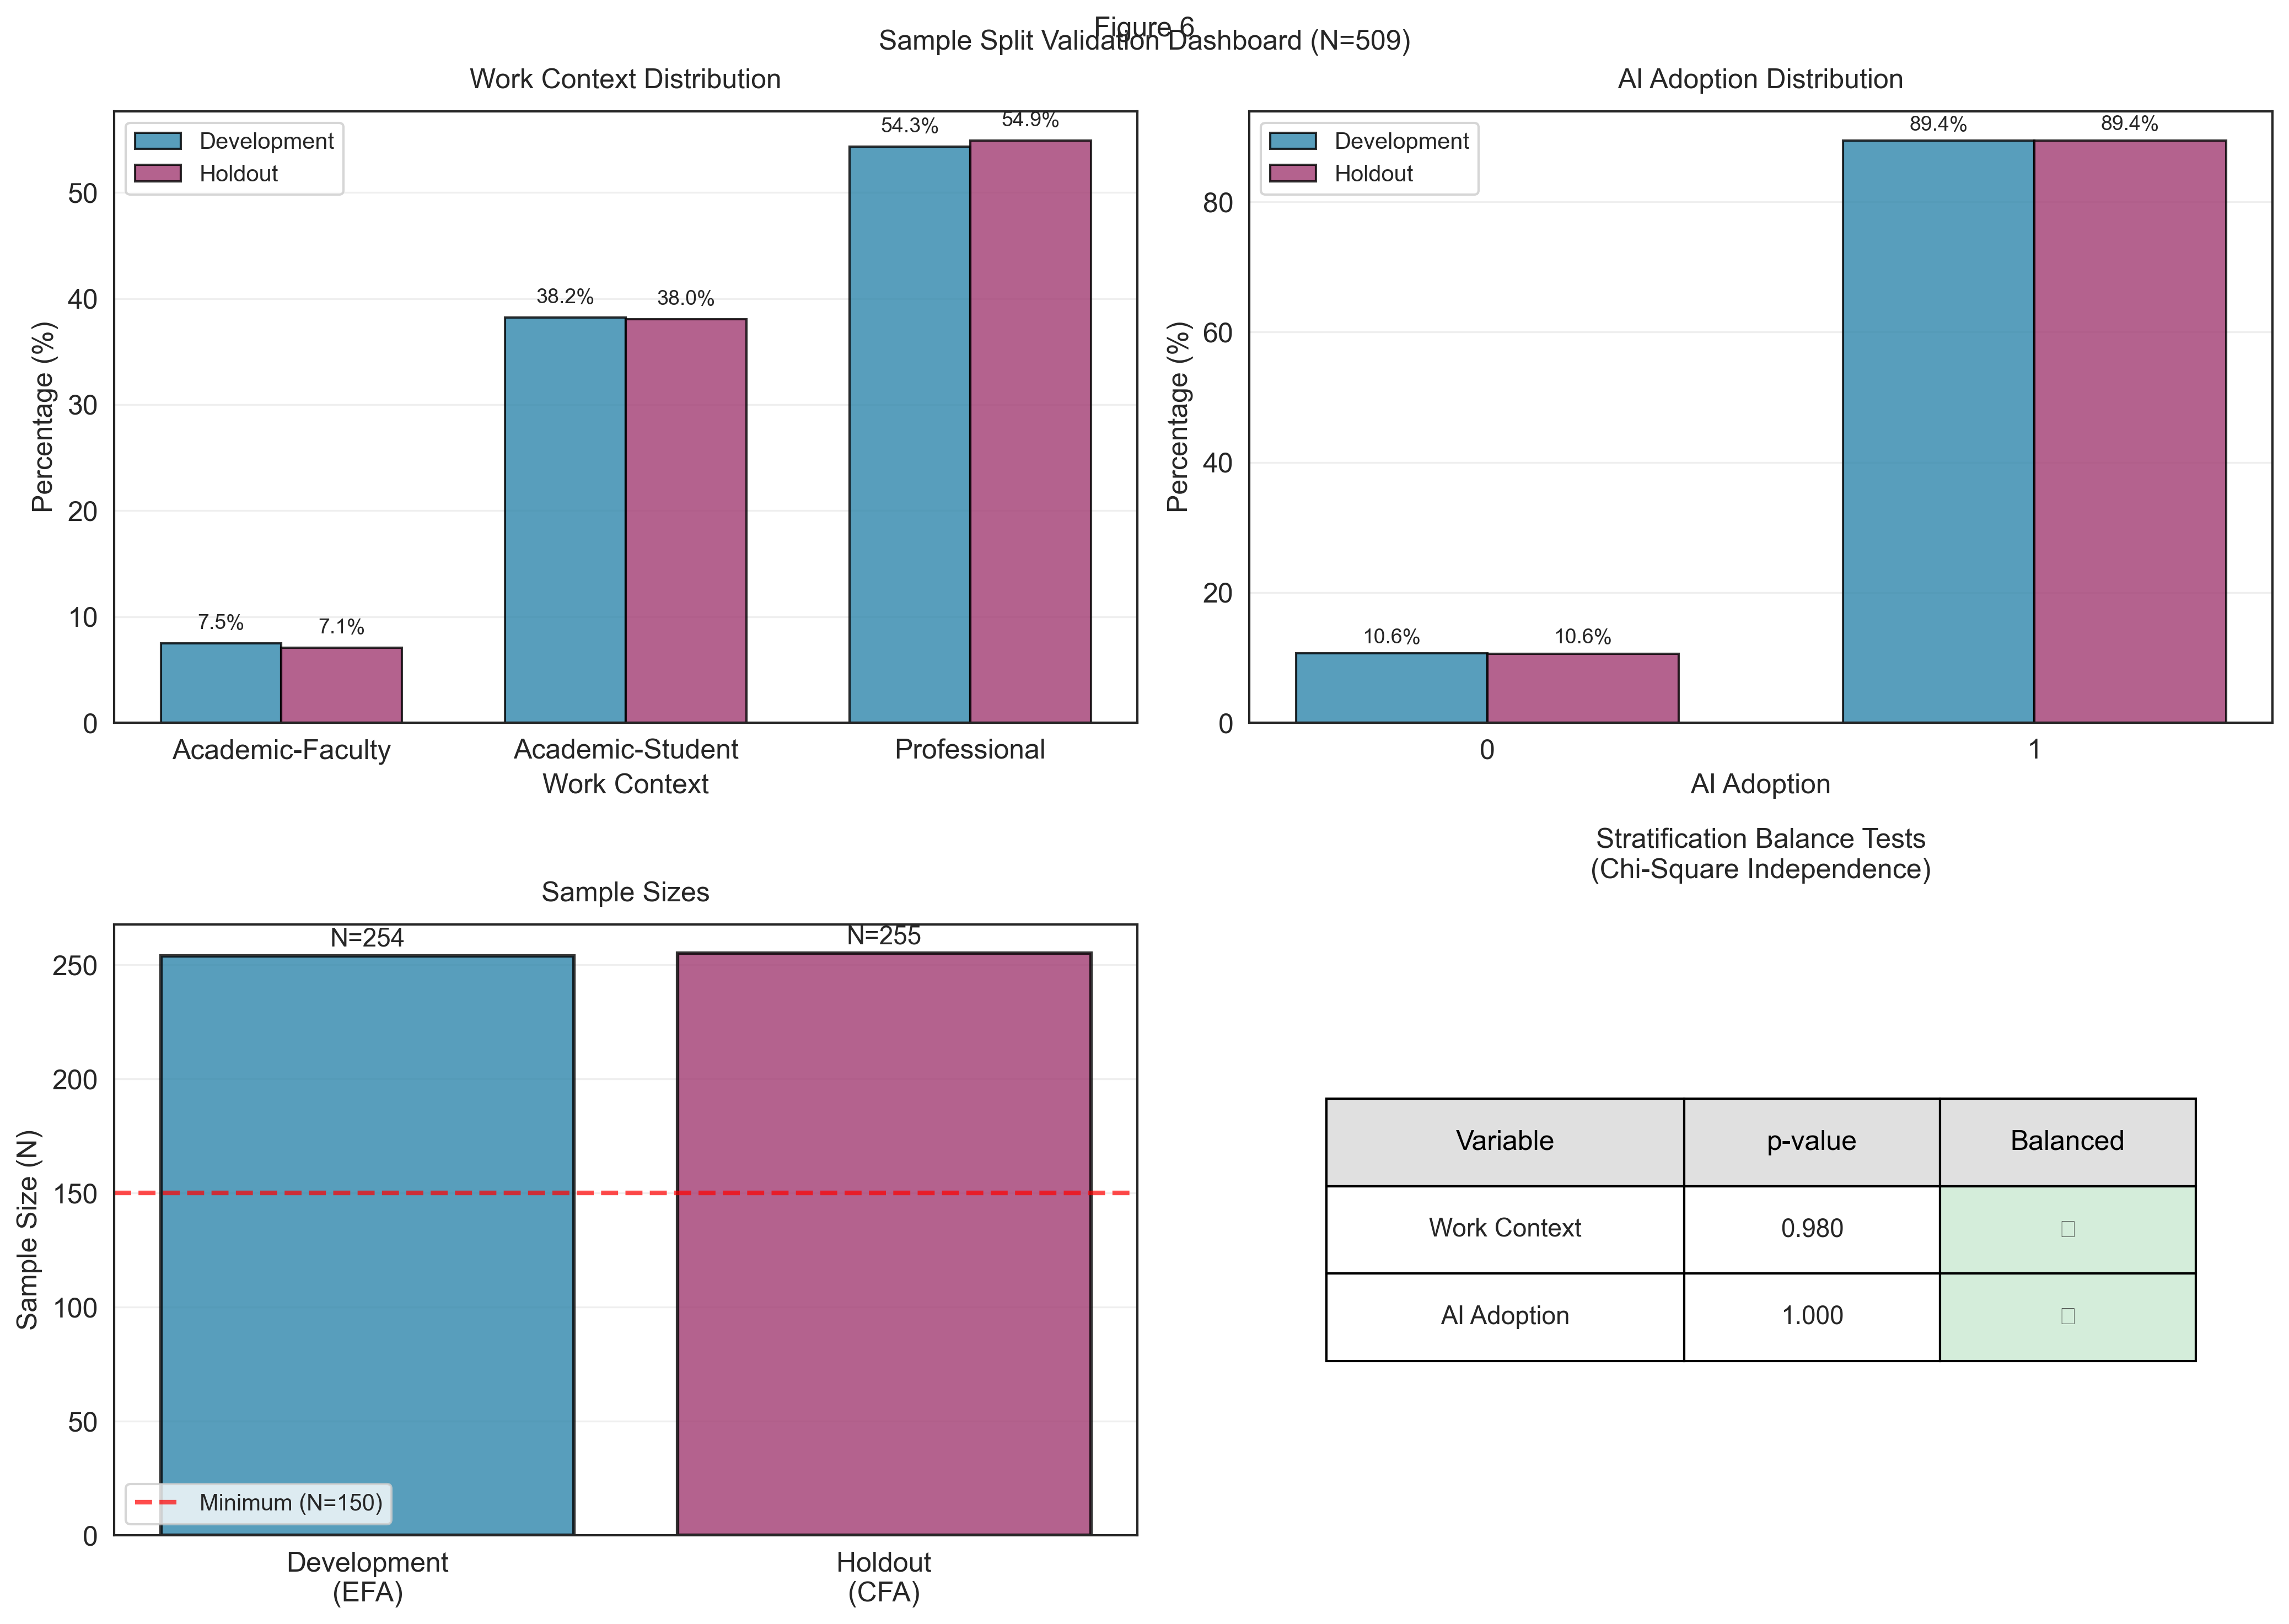


✅ FIGURE 6: Sample Split Validation Dashboard
   Saved to: ../results/plots/sample_split_stratification.png
   Development N=254, Holdout N=255
   Work Context balanced: Yes (p=0.980)
   AI Adoption balanced: Yes (p=1.000)


In [144]:
# ============================================================
# FIGURE 6: Sample Split Validation Dashboard
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

# APA Style: Clean, professional formatting
sns.set_style('white')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.linewidth'] = 1.0

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Get stratification variables
df_dev_plot = df_dev.copy()
df_holdout_plot = df_holdout.copy()
df_dev_plot['Sample'] = 'Development'
df_holdout_plot['Sample'] = 'Holdout'
df_combined = pd.concat([df_dev_plot, df_holdout_plot])

# 1. Work Context Distribution
ax1 = axes[0, 0]
work_context_counts = df_combined.groupby(['Sample', 'Work_Context']).size().unstack(fill_value=0)
work_context_pct = work_context_counts.div(work_context_counts.sum(axis=1), axis=0) * 100

x = np.arange(len(work_context_pct.columns))
width = 0.35
bars1 = ax1.bar(x - width/2, work_context_pct.loc['Development'], width, 
                label='Development', color='#2E86AB', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, work_context_pct.loc['Holdout'], width, 
                label='Holdout', color='#A23B72', alpha=0.8, edgecolor='black')

ax1.set_xlabel('Work Context', fontsize=12)
ax1.set_ylabel('Percentage (%)', fontsize=12)
ax1.set_title('Work Context Distribution', fontsize=12, pad=10)
ax1.set_xticks(x)
ax1.set_xticklabels(work_context_pct.columns, rotation=0)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Add percentage labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# 2. AI Adoption Distribution
ax2 = axes[0, 1]
adoption_counts = df_combined.groupby(['Sample', 'AI_Adoption']).size().unstack(fill_value=0)
adoption_pct = adoption_counts.div(adoption_counts.sum(axis=1), axis=0) * 100

x = np.arange(len(adoption_pct.columns))
bars3 = ax2.bar(x - width/2, adoption_pct.loc['Development'], width, 
                label='Development', color='#2E86AB', alpha=0.8, edgecolor='black')
bars4 = ax2.bar(x + width/2, adoption_pct.loc['Holdout'], width, 
                label='Holdout', color='#A23B72', alpha=0.8, edgecolor='black')

ax2.set_xlabel('AI Adoption', fontsize=12)
ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.set_title('AI Adoption Distribution', fontsize=12, pad=10)
ax2.set_xticks(x)
ax2.set_xticklabels(adoption_pct.columns, rotation=0)
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# Add percentage labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# 3. Sample Sizes Comparison
ax3 = axes[1, 0]
sample_sizes = [len(df_dev), len(df_holdout)]
sample_labels = ['Development\n(EFA)', 'Holdout\n(CFA)']
bars5 = ax3.bar(sample_labels, sample_sizes, color=['#2E86AB', '#A23B72'], 
                alpha=0.8, edgecolor='black', linewidth=1.5)

ax3.set_ylabel('Sample Size (N)', fontsize=12)
ax3.set_title('Sample Sizes', fontsize=12, pad=10)
ax3.axhline(y=150, color='red', linestyle='--', linewidth=2, label='Minimum (N=150)', alpha=0.7)
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# Add sample size labels
for bar in bars5:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'N={int(height)}', ha='center', va='bottom', fontsize=11)

# 4. Chi-Square Test Results (Validation Table)
ax4 = axes[1, 1]
ax4.axis('off')

validation_data = [
    ['Work Context', f'{p_work_context:.3f}', '✓' if p_work_context > 0.05 else '×'],
    ['AI Adoption', f'{p_ai_adoption:.3f}', '✓' if p_ai_adoption > 0.05 else '×']
]

table = ax4.table(cellText=validation_data,
                 colLabels=['Variable', 'p-value', 'Balanced'],
                 cellLoc='center',
                 loc='center',
                 colWidths=[0.35, 0.25, 0.25])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 3)

# Style header per APA
for j in range(3):
    cell = table[(0, j)]
    cell.set_facecolor('#e0e0e0')
    cell.set_text_props(color='black', fontsize=12)

# Color status column
for i in range(1, 3):
    status = validation_data[i-1][2]
    if status == '✓':
        table[(i, 2)].set_facecolor('#d4edda')
    else:
        table[(i, 2)].set_facecolor('#f8d7da')

ax4.set_title('Stratification Balance Tests\n(Chi-Square Independence)', 
             fontsize=12, pad=20)

# Main title
fig.suptitle(f'Figure 6', fontsize=12, y=0.98)
fig.text(0.5, 0.96, f'Sample Split Validation Dashboard (N={len(df)})', 
         ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('../results/plots/sample_split_stratification.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("✅ FIGURE 6: Sample Split Validation Dashboard")
print("="*80)
print(f"   Saved to: ../results/plots/sample_split_stratification.png")
print(f"   Development N={len(df_dev)}, Holdout N={len(df_holdout)}")
print(f"   Work Context balanced: {'Yes (p={:.3f})'.format(p_work_context) if p_work_context > 0.05 else 'No'}")
print(f"   AI Adoption balanced: {'Yes (p={:.3f})'.format(p_ai_adoption) if p_ai_adoption > 0.05 else 'No'}")


## 9. Configuration Notes

**Subsample Selection**: Set `SUBSAMPLE_MODE` in Section 0 to analyze specific populations:
- `'full'`: All participants (N varies by data)
- `'students'`: Academic-Student context only
- `'professionals'`: Professional context only

**Purpose**: Context-specific validation based on Work Context heterogeneity findings

**Impact**: All statistics, figures, and exported files reflect selected subsample

**Workflow**: After mode change → Re-run Notebook 00 → Re-run Notebooks 01-04 for complete validation